In [190]:
import numpy as np
from sumolib import checkBinary
import math
import random
import time
import traci
import os
import sys
import psutil
import optparse
import keras
import tensorflow as tf 
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

from keras.models import Model
from keras.layers import Input,Dense,Dropout,dot,Flatten

os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

# Vehicle class

In [191]:
class Vehicle:
    def __init__(self,vid,waiting_time,vtype):
        self.vid=vid
        self.waiting_time=waiting_time
        self.vtype=vtype

# Environment

In [192]:
class Sumo:
    
    RedYellowGreenStates=["rrrrrGGrrrrrrGGr","rGGrrrrrrGGrrrrr","rrrrrrrrrrgrGGGG","GGGGrrrrrrrrrrgr","rrgrGGGGrrrrrrrr","rrrrrrgrGGGGrrrr","GrrrrrGrGrrrrrGr","rrGrGrrrrrGrGrrr"]
    
    def __init__(self,K,Z):
        self.K=K # K,Z are tunable constants
        self.Z=Z
        self.nearby_vehicles=[[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]
        self.count=0
        self.previous_eval=0
        if 'SUMO_HOME' in os.environ:
            tools=os.path.join(os.environ['SUMO_HOME'],'tools')
            sys.path.append(tools)
   
        else: 
            sys.exit("please declare environment variable 'SUMO_HOME'")
            
    def getSumoBinary(self):

        sumoBinary = checkBinary('sumo-gui')
        return sumoBinary
    
    def getState(self):
        incomming_state=np.zeros([12,4]) # definition of a one row is (number of vehicles in that lane,maximum waiting time,emergency or not)
        outgoing_state=np.ones(4) #will get the negetive impact of this [Left,Right,Bottom,Top]
        for i in range(1,5):
            for j in range(0,3):
                all_vehicles_on_lane = traci.lane.getLastStepVehicleIDs(str(i)+"si_"+str(j))
                
                for vehicle in self.nearby_vehicles[i-1][j]:# removing the vehicle from the memory which has went through the junction
                    if vehicle.vid not in all_vehicles_on_lane:
                        nearby_vehicle_on_lane=self.nearby_vehicles[i-1][j]
                        nearby_vehicle_on_lane.remove(vehicle)
                        self.nearby_vehicles[i-1][j]=nearby_vehicle_on_lane
                        
                for vehicle_id in all_vehicles_on_lane:
#                     getLanePosition outputs the position of the vehicle with respect to start end of the lane that is not the junction side
                    if(traci.vehicle.getLanePosition(vehicle_id)>=132):# consider vehicles which is 100M near or less to the junction lan length is 232
                        flag=1
                        for e,vehicle in enumerate(self.nearby_vehicles[i-1][j]):
                            if vehicle.vid==vehicle_id: #checking for exsisting vehicles
                                vehicle.waiting_time+=1
                                vehicle_list=self.nearby_vehicles[i-1][j]
                                vehicle_list[e]=vehicle # replace the old vehicle object with updated one
                                self.nearby_vehicles[i-1][j]=vehicle_list
                                flag=0
                                break
                        if(flag):
                            #register the new vehicle
                            new_vehicle_obj=Vehicle(vehicle_id,0,traci.vehicle.getTypeID(vehicle_id))
                            nearby_vehicle_on_lane=self.nearby_vehicles[i-1][j]
                            nearby_vehicle_on_lane.append(new_vehicle_obj)
                            self.nearby_vehicles[i-1][j]=nearby_vehicle_on_lane
                            
                #prepairing incomming state          
                emergency_waiting_time=0
                waiting_time_distribution=[]
                for vehicle in self.nearby_vehicles[i-1][j]:
                    if vehicle.vtype == "emergency":
                        if vehicle.waiting_time > emergency_waiting_time:
                            emergency_waiting_time = vehicle.waiting_time
                            
                    waiting_time_distribution.append(vehicle.waiting_time)
                    
                if not waiting_time_distribution:# append 0 to empty list to get rid of nan issue
                    waiting_time_distribution.append(0)
                    
                waiting_time_mean =  np.mean(waiting_time_distribution)
                waiting_time_std = np.std(waiting_time_distribution)    
                
                #Scalling state representation
                #maximum waiting time of a vehicle is 100s
                #maximum number of vehicles that can be fit in to 100M range is 17 
                
                incomming_state[j+(i-1)*3][0] = len(self.nearby_vehicles[i-1][j])/17 # adding queue length
                
                if(waiting_time_mean>100): #adding average waiting time
                    incomming_state[j+(i-1)*3][1] = 1
                else:
                    incomming_state[j+(i-1)*3][1] = waiting_time_mean/100
                    
                if(waiting_time_std>100): #adding standard deviation 
                    incomming_state[j+(i-1)*3][2] = 1
                else:
                    incomming_state[j+(i-1)*3][2] = waiting_time_std/100
                 
                if(emergency_waiting_time>100): # addimg emergency waiting time
                    incomming_state[j+(i-1)*3][3] = 1
                else:
                    incomming_state[j+(i-1)*3][3] = emergency_waiting_time/100
                
        
            #prepairing outgoing state      
            for vehicle_id in traci.lane.getLastStepVehicleIDs(str(i)+"o_0"):
                if(traci.vehicle.getLanePosition(vehicle_id) >= 386):#length of an outgoing road is 486M
                    outgoing_state[i-1] = outgoing_state[i-1]-1/17 # - because of to get the negetive impact when the road is blocked
       
            #transforming outgoing state into attention state
            outgoing_state_final=np.ones(12)
            outgoing_state_final[4] = outgoing_state_final[6] = outgoing_state_final[11] = outgoing_state[0]
            outgoing_state_final[1] = outgoing_state_final[8] = outgoing_state_final[9] = outgoing_state[1]
            outgoing_state_final[2] = outgoing_state_final[3] = outgoing_state_final[10] = outgoing_state[2]
            outgoing_state_final[0] = outgoing_state_final[5] = outgoing_state_final[7] = outgoing_state[3]
            
        return [incomming_state.reshape(1,12,4),outgoing_state_final.reshape(1,12,1)]
        
    def changePhase(self,next_phase_index):
       
        current_phase=traci.trafficlight.getRedYellowGreenState('0')
        next_phase=self.RedYellowGreenStates[next_phase_index]
        
        
        if(next_phase != current_phase):#generate yellow phase
            yellow_phase = ""
            for i in range(0, len(current_phase)):
                if(current_phase[i].lower()=="g" and next_phase[i].lower()=="r"):

                    yellow_phase = yellow_phase+"y"
                else:
                    yellow_phase = yellow_phase+current_phase[i]

            traci.trafficlight.setRedYellowGreenState('0',yellow_phase) #set yellow phase

            for i in range(3): # allow yellow phase for 3 seconds
                traci.simulationStep()
            traci.trafficlight.setRedYellowGreenState('0',next_phase)
        return
    
    def reward(self,current_state):
        
        #calculating the mean and the std of the distribution for the current state   
        reg_waiting_time_mean =  np.mean(current_state[0][0][:,1]*100)
        reg_waiting_time_std = np.std(current_state[0][0][:,1]*100)
        
        emg_waiting_time_mean =  np.mean(current_state[0][0][:,3]*100)
        emg_waiting_time_std = np.std(current_state[0][0][:,3]*100)
#         print(current_state[0])
#         print(reg_wainting_time_mean)
        reward = 50 - ((reg_waiting_time_mean + self.K*reg_waiting_time_std) + self.Z*(emg_waiting_time_mean + self.K*emg_waiting_time_std)) 
#         reward = self.previous_eval - current_eval
#         self.previous_eval = current_eval
        
        return reward,round(reg_waiting_time_mean,2),round(emg_waiting_time_mean,2),round(reg_waiting_time_std,2),round(emg_waiting_time_std,2)


# Deep Q-network

In [193]:
def createDQN():
    incomming_vehicles=Input(shape=(12,4))
    outgoing_vehicles=Input(shape=(12,1))
    
    Dense1_out=Dense(20,name="Dense1",activation='relu')(incomming_vehicles)
    Dense2_out=Dense(10,name="Dense2",activation='relu')(Dense1_out)
#     Dropout1_out=Dropout(.2,name="Dropout1")(Dense2_out)
#     Dense3_out=Dense(5,name="Dense3",activation='relu')(Dense2_out)
    
#     Dense4_out=Dense(1,name="Dense4",activation='relu')(outgoing_vehicles)
#     Dot_out=dot([Dense2_out,Dense4_out],axes=1, normalize=False)
    Flatten_out=Flatten()(Dense2_out)
    
    Dense5_out=Dense(8,name="Dense5")(Flatten_out)#no activation function for last layer
    
    model = Model(inputs=[incomming_vehicles,outgoing_vehicles], outputs=[Dense5_out])
    model.compile(optimizer="Adam",loss="categorical_crossentropy")
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    return model

# Replay Memory

In [194]:
class ReplayMemory:
    def __init__(self,capacity,initial_state,initial_action):
        self.capacity=capacity
        self.replay_memory=[]
        self.push_count=0
        self.buffer_state=initial_state
        self.buffer_action=initial_action
    
    #also the next state cannot be directly observerd here because it takes time for vehicles to move and actualy become another
    #state after making a decision.
    def addToReplayBuffuer(self,current_state,action,reward):#here the reward is reward for the previous action
        
        experience=[self.buffer_state,self.buffer_action,reward,current_state]
        #buffer_state and buffer_action contains the previous state and the action now this reward and current state is corresponding to that experience
        self.buffer_state=current_state
        self.buffer_action=action
        
        if(len(self.replay_memory)<self.capacity):
            self.replay_memory.append(experience)
        else:
                # replace the oldest  experience with the new one in replay memory
            self.replay_memory[self.push_count%self.capacity]=experience
            self.push_count +=1
            
    def replay(self,replay_batch_size):

        if len(self.replay_memory) < replay_batch_size: 
            return

        replay_samples = random.sample(self.replay_memory, replay_batch_size)
#         print('experience replay....')
        for sample in replay_samples:

            state, action, reward, new_state = sample
            
            target = PolicyNetwork.predict(state)
            
            #only with fixed q targets
            #Q_future = max(TargetNetwork.predict(new_state)[0])
            
            #with double network concept
            best_action_new_state = np.argmax(PolicyNetwork.predict(new_state)[0])
            Q_future = TargetNetwork.predict(new_state)[0][best_action_new_state] 
            #q value for the best action from the target network
            
            
#             print(TargetNetwork.predict(new_state)[0])
            target[0][action] = reward + Q_future * gamma
            PolicyNetwork.fit(state, target, epochs=1, verbose=0)


# Agent

In [195]:
class Agent:
    
    def __init__(self,tau):
        self.step_number=0
        self.tau = tau
         
    def getAction(self,state):
        epsilon = math.exp(-1.*self.step_number*epsilon_decay)
        epsilon = max(epsilon_min, epsilon)
        self.step_number+=1
        print(epsilon)
        if np.random.random() < epsilon:
            return np.random.randint(0,action_space)
        else:
            return np.argmax(PolicyNetwork.predict(state)[0])
             
    def update_target_graph(self):
        weights = PolicyNetwork.get_weights()
        target_weights =TargetNetwork.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
        TargetNetwork.set_weights(target_weights)    
        

In [204]:
action_space=8 #action is to choose next phase,agent will take an action within last 4seconds of the current phase
minimum_phase_duration=12
PolicyNetwork=createDQN()
PolicyNetwork.summary()
TargetNetwork=createDQN()
#parameaters to be tuned

gamma = 0.85
epsilon = 1.0
epsilon_min = 0.08
epsilon_decay = 0.00005
learning_rate = 0.005
tau = .125
replay_memory_capacity=70000

decisions_per_episode=10
replay_batch_size=256

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_77 (InputLayer)        (None, 12, 4)             0         
_________________________________________________________________
Dense1 (Dense)               (None, 12, 20)            100       
_________________________________________________________________
Dense2 (Dense)               (None, 12, 10)            210       
_________________________________________________________________
flatten_37 (Flatten)         (None, 120)               0         
_________________________________________________________________
Dense5 (Dense)               (None, 8)                 968       
Total params: 1,278
Trainable params: 1,278
Non-trainable params: 0
_________________________________________________________________


# Plot history

In [205]:
def plot(episode_count,history,ylabel,color,label):
    ax.plot(episode_count,history,color=color, label=label)
    ax.set_xlabel('number of episodes')
    ax.set_ylabel(ylabel)
    ax.set_title('Training....')
    fig.canvas.draw()
    

# Training

In [206]:
sumo_env=Sumo(K=1,Z=2)
initial_state=[np.zeros([12,4]).reshape(1,12,4),np.zeros([12,1]).reshape(1,12,1)]
replayMemory=ReplayMemory(replay_memory_capacity,initial_state,0)
agent=Agent(tau)

count=1   
decision_count=1
episode_count=[]
regular_waiting_history=[]
emergency_waiting_history=[]
regular_std_history=[]
emergency_std_history=[]
reward_history=[]
episode_no=1


In [207]:
traci.start([sumo_env.getSumoBinary(), "-c", "cross3ltl.sumocfg", '--start'])
while traci.simulation.getMinExpectedNumber()>0:
  
        traci.simulationStep()

        if(count==12):#agent will make a decision at the 12th second of the current phase
            current_state=sumo_env.getState()
            action=agent.getAction(current_state)
            sumo_env.changePhase(action)
          
            count=1
            
            reward,regular_waiting,emergency_waiting,regular_std,emg_std=sumo_env.reward(current_state)
            replayMemory.addToReplayBuffuer(current_state,action,reward)
            
            if(decision_count==decisions_per_episode):
                
                decision_count=1
               
                agent.update_target_graph()#updating target graph is performed after each episode
                episode_count.append(episode_no)
                episode_no+=1
                
                regular_waiting_history.append(regular_waiting)
                emergency_waiting_history.append(emergency_waiting)
                
                regular_std_history.append(regular_std)
                emergency_std_history.append(emg_std)
                
                reward_history.append(reward)
                
                replayMemory.replay(replay_batch_size)#experience replay is performed after each episode
#                 print('reg_waiting : ',regular_waiting,'emg_waiting : ',emergency_waiting,'reg_std : ',regular_std,'emg_std : ',emg_std,'reward : ',reward_history)
            else:
                decision_count+=1
        else:
            count+=1
            
traci.close()

1.0
0.9999500012499791
0.9999000049998333
0.9998500112494375
0.9998000199986667
0.999750031247396
0.9997000449955004
0.9996500612428548
0.9996000799893344
0.9995501012348142
0.9995001249791693
0.9994501512222747
0.9994001799640054
0.9993502112042366
0.9993002449428433
0.9992502811797007
0.9992003199146837
0.9991503611476675
0.9991004048785274
0.9990504511071381
0.999000499833375
0.9989505510571132
0.9989006047782276
0.9988506609965937
0.9988007197120864
0.9987507809245809
0.9987008446339523
0.9986509108400758
0.9986009795428267
0.99855105074208
0.9985011244377109
0.9984512006295946
0.9984012793176064
0.9983513605016212
0.9983014441815146
0.9982515303571615
0.9982016190284373
0.9981517101952171
0.9981018038573761
0.9980519000147897
0.9980019986673331
0.9979520998148814
0.99790220345731
0.9978523095944941
0.997802418226309
0.9977525293526299
0.9977026429733321
0.997652759088291
0.9976028776973818
0.9975529988004797
0.9975031223974601
0.9974532484881984
0.9974033770725698
0.99735350815044

0.9784359026643293
0.9783869820922206
0.9783380639660794
0.9782891482857833
0.97824023505121
0.9781913242622374
0.9781424159187431
0.9780935100206047
0.9780446065677002
0.9779957055599072
0.9779468069971035
0.9778979108791668
0.9778490172059748
0.9778001259774054
0.9777512371933363
0.9777023508536453
0.9776534669582102
0.9776045855069088
0.9775557064996189
0.9775068299362182
0.9774579558165845
0.9774090841405957
0.9773602149081297
0.9773113481190642
0.9772624837732771
0.9772136218706462
0.9771647624110493
0.9771159053943643
0.9770670508204692
0.9770181986892416
0.9769693490005595
0.9769205017543008
0.9768716569503434
0.9768228145885651
0.9767739746688439
0.9767251371910575
0.976676302155084
0.9766274695608013
0.9765786394080872
0.9765298116968197
0.9764809864268769
0.9764321635981364
0.9763833432104764
0.9763345252637747
0.9762857097579093
0.9762368966927583
0.9761880860681994
0.9761392778841107
0.9760904721403703
0.9760416688368561
0.975992867973446
0.975944069550018
0.975895273566450

0.957097511332938
0.9570496576537233
0.9570018063671327
0.9569539574730467
0.9569061109713456
0.9568582668619097
0.9568104251446194
0.9567625858193554
0.9567147488859977
0.9566669143444269
0.9566190821945234
0.9565712524361676
0.9565234250692399
0.9564756000936208
0.9564277775091907
0.95637995731583
0.9563321395134192
0.9562843241018388
0.9562365110809692
0.9561887004506909
0.9561408922108843
0.95609308636143
0.9560452829022084
0.9559974818330998
0.9559496831539852
0.9559018868647446
0.9558540929652589
0.9558063014554083
0.9557585123350735
0.955710725604135
0.9556629412624733
0.9556151593099689
0.9555673797465024
0.9555196025719545
0.9554718277862054
0.955424055389136
0.9553762853806267
0.9553285177605582
0.9552807525288108
0.9552329896852655
0.9551852292298025
0.9551374711623027
0.9550897154826465
0.9550419621907147
0.9549942112863876
0.9549464627695462
0.9548987166400709
0.9548509728978424
0.9548032315427414
0.9547554925746483
0.954707755993444
0.9546600217990092
0.9546122899912244
0

0.9363181091883427
0.9362712944532614
0.9362244820588583
0.9361776720050164
0.9361308642916188
0.9360840589185483
0.936037255885688
0.9359904551929208
0.9359436568401297
0.9358968608271978
0.935850067154008
0.9358032758204433
0.9357564868263869
0.9357097001717217
0.9356629158563308
0.9356161338800971
0.9355693542429038
0.9355225769446338
0.9354758019851703
0.9354290293643963
0.935382259082195
0.9353354911384492
0.9352887255330421
0.9352419622658569
0.9351952013367766
0.9351484427456842
0.9351016864924631
0.935054932576996
0.9350081809991664
0.9349614317588572
0.9349146848559515
0.9348679402903326
0.9348211980618836
0.9347744581704874
0.9347277206160275
0.934680985398387
0.9346342525174487
0.9345875219730962
0.9345407937652125
0.9344940678936807
0.9344473443583842
0.934400623159206
0.9343539042960294
0.9343071877687374
0.9342604735772135
0.9342137617213409
0.9341670522010025
0.9341203450160818
0.934073640166462
0.9340269376520263
0.9339802374726578
0.93393353962824
0.9338868441186561
0.

0.9159440472151089
0.9158982511576591
0.915852457389955
0.915806665911882
0.9157608767233256
0.9157150898241715
0.915669305214305
0.9156235228936119
0.9155777428619776
0.9155319651192876
0.9154861896654275
0.9154404165002828
0.9153946456237393
0.9153488770356824
0.9153031107359976
0.9152573467245706
0.915211585001287
0.9151658255660323
0.9151200684186923
0.9150743135591524
0.9150285609872982
0.9149828107030155
0.9149370627061898
0.9148913169967068
0.914845573574452
0.9147998324393112
0.91475409359117
0.9147083570299139
0.9146626227554289
0.9146168907676003
0.914571161066314
0.9145254336514556
0.9144797085229107
0.9144339856805652
0.9143882651243046
0.9143425468540146
0.914296830869581
0.9142511171708896
0.9142054057578259
0.9141596966302757
0.9141139897881247
0.9140682852312588
0.9140225829595635
0.9139768829729248
0.9139311852712282
0.9138854898543596
0.9138397967222047
0.9137941058746493
0.9137484173115791
0.91370273103288
0.9136570470384378
0.9136113653281381
0.9135656859018669
0.91

0.8961029258536849
0.8960581218275021
0.8960133200414647
0.8959685204954607
0.8959237231893779
0.8958789281231044
0.8958341352965282
0.8957893447095374
0.89574455636202
0.8956997702538639
0.8956549863849572
0.895610204755188
0.8955654253644444
0.8955206482126143
0.8954758732995859
0.895431100625247
0.895386330189486
0.8953415619921908
0.8952967960332495
0.8952520323125501
0.895207270829981
0.8951625115854299
0.8951177545787851
0.8950729998099347
0.8950282472787668
0.8949834969851695
0.894938748929031
0.8948940031102394
0.8948492595286827
0.8948045181842492
0.894759779076827
0.8947150422063043
0.894670307572569
0.8946255751755097
0.8945808450150142
0.8945361170909709
0.8944913914032678
0.8944466679517933
0.8944019467364355
0.8943572277570824
0.8943125110136224
0.8942677965059438
0.8942230842339346
0.8941783741974831
0.8941336663964776
0.8940889608308062
0.8940442575003572
0.8939995564050189
0.8939548575446795
0.8939101609192273
0.8938654665285504
0.8938207743725372
0.8937760844510758
0.

0.8768669574493531
0.876823115197546
0.8767792751377967
0.8767354372699957
0.8766916015940333
0.8766477681097997
0.8766039368171857
0.8765601077160815
0.8765162808063776
0.8764724560879643
0.8764286335607323
0.8763848132245717
0.8763409950793732
0.8762971791250274
0.8762533653614243
0.8762095537884547
0.8761657444060089
0.8761219372139776
0.8760781322122511
0.8760343294007198
0.8759905287792744
0.8759467303478053
0.8759029341062031
0.8758591400543583
0.8758153481921612
0.8757715585195026
0.8757277710362728
0.8756839857423625
0.8756402026376621
0.8755964217220622
0.8755526429954533
0.8755088664577262
0.8754650921087711
0.8754213199484788
0.8753775499767398
0.8753337821934447
0.8752900165984839
0.8752462531917483
0.8752024919731284
0.8751587329425146
0.8751149760997976
0.8750712214448682
0.8750274689776166
0.8749837186979339
0.8749399706057105
0.8748962247008368
0.8748524809832039
0.8748087394527021
0.8747650001092222
0.8747212629526547
0.8746775279828904
0.87463379519982
0.8745900646033

0.8579152161952602
0.8578723215068266
0.8578294289630738
0.8577865385638945
0.8577436503091816
0.8577007641988279
0.857657880232726
0.8576149984107688
0.8575721187328492
0.8575292411988599
0.8574863658086935
0.8574434925622432
0.8574006214594017
0.8573577525000615
0.8573148856841158
0.8572720210114575
0.857229158481979
0.8571862980955736
0.8571434398521337
0.8571005837515526
0.8570577297937229
0.8570148779785375
0.8569720283058894
0.8569291807756713
0.856886335387776
0.8568434921420968
0.8568006510385261
0.8567578120769572
0.8567149752572828
0.8566721405793958
0.8566293080431892
0.8565864776485558
0.8565436493953885
0.8565008232835805
0.8564579993130246
0.8564151774836135
0.8563723577952405
0.8563295402477983
0.85628672484118
0.8562439115752786
0.8562011004499868
0.8561582914651978
0.8561154846208046
0.8560726799167001
0.8560298773527772
0.8559870769289292
0.8559442786450487
0.8559014825010289
0.8558586884967629
0.8558158966321436
0.8557731069070641
0.8557303193214173
0.855687533875096

0.8394570207692074
0.8394150489674727
0.8393730792642756
0.8393311116595112
0.8392891461530747
0.839247182744861
0.8392052214347653
0.8391632622226826
0.839121305108508
0.8390793500921367
0.8390373971734638
0.8389954463523844
0.8389534976287937
0.8389115510025866
0.8388696064736585
0.8388276640419042
0.8387857237072193
0.8387437854694986
0.8387018493286374
0.8386599152845308
0.8386179833370739
0.8385760534861622
0.8385341257316904
0.8384922000735541
0.8384502765116482
0.838408355045868
0.8383664356761086
0.8383245184022654
0.8382826032242334
0.838240690141908
0.8381987791551844
0.8381568702639576
0.8381149634681231
0.8380730587675759
0.8380311561622114
0.8379892556519247
0.8379473572366113
0.8379054609161661
0.8378635666904847
0.8378216745594622
0.8377797845229938
0.837737896580975
0.8376960107333009
0.8376541269798667
0.837612245320568
0.8375703657552998
0.8375284882839575
0.8374866129064366
0.837444739622632
0.8374028684324394
0.8373609993357538
0.8373191323324709
0.8372772674224858


0.8214370274599259
0.821395956635332
0.8213548878642281
0.8213138211465114
0.8212727564820792
0.821231693870829
0.821190633312658
0.8211495748074634
0.821108518355143
0.8210674639555937
0.8210264116087131
0.8209853613143987
0.8209443130725476
0.8209032668830571
0.820862222745825
0.8208211806607484
0.8207801406277248
0.8207391026466514
0.8206980667174258
0.8206570328399455
0.8206160010141077
0.8205749712398099
0.8205339435169495
0.820492917845424
0.8204518942251308
0.8204108726559673
0.8203698531378311
0.8203288356706193
0.8202878202542297
0.8202468068885598
0.8202057955735067
0.8201647863089683
0.8201237790948417
0.8200827739310246
0.8200417708174144
0.8200007697539087
0.8199597707404048
0.8199187737768004
0.819877778862993
0.81983678599888
0.819795795184359
0.8197548064193274
0.8197138197036828
0.8196728350373229
0.8196318524201449
0.8195908718520467
0.8195498933329256
0.8195089168626792
0.8194679424412052
0.819426970068401
0.8193859997441643
0.8193450314683924
0.8193040652409832
0.81

0.8037636666232993
0.803723479444656
0.8036832942753214
0.803643111115195
0.8036029299641764
0.8035627508221651
0.8035225736890608
0.8034823985647628
0.8034422254491708
0.8034020543421844
0.8033618852437031
0.8033217181536265
0.8032815530718542
0.8032413899982859
0.803201228932821
0.8031610698753591
0.8031209128258
0.8030807577840431
0.8030406047499881
0.8030004537235346
0.8029603047045822
0.8029201576930307
0.8028800126887795
0.8028398696917284
0.8027997287017768
0.8027595897188248
0.8027194527427716
0.802679317773517
0.8026391848109607
0.8025990538550025
0.8025589249055418
0.8025187979624785
0.8024786730257121
0.8024385500951424
0.8023984291706692
0.802358310252192
0.8023181933396105
0.8022780784328246
0.8022379655317338
0.8021978546362379
0.8021577457462368
0.8021176388616299
0.8020775339823172
0.8020374311081983
0.801997330239173
0.801957231375141
0.801917134516002
0.8018770396616559
0.8018369468120025
0.8017968559669413
0.8017567671263723
0.8017166802901953
0.8016765954583099
0.80

0.7864705512258485
0.7864312286813591
0.7863919081029476
0.786352589490516
0.7863132728439658
0.7862739581631988
0.7862346454481167
0.7861953346986212
0.7861560259146141
0.786116719095997
0.7860774142426717
0.78603811135454
0.7859988104315035
0.7859595114734641
0.7859202144803235
0.7858809194519834
0.7858416263883455
0.7858023352893118
0.7857630461547839
0.7857237589846635
0.7856844737788526
0.7856451905372529
0.7856059092597661
0.7855666299462942
0.7855273525967388
0.7854880772110018
0.785448803788985
0.7854095323305902
0.7853702628357192
0.7853309953042739
0.785291729736156
0.7852524661312675
0.7852132044895102
0.7851739448107858
0.7851346870949965
0.7850954313420436
0.7850561775518294
0.7850169257242557
0.7849776758592244
0.7849384279566372
0.784899182016396
0.7848599380384028
0.7848206960225594
0.7847814559687678
0.7847422178769299
0.7847029817469474
0.7846637475787225
0.7846245153721568
0.7845852851271525
0.7845460568436115
0.7845068305214355
0.7844676061605266
0.7844283837607867


0.7695110237075758
0.7694725491182631
0.769434076452632
0.7693956057105859
0.7693571368920288
0.7693186699968646
0.769280205024997
0.76924174197633
0.7692032808507674
0.7691648216482129
0.7691263643685705
0.769087909011744
0.7690494555776373
0.7690110040661542
0.7689725544771986
0.7689341068106744
0.7688956610664855
0.7688572172445357
0.768818775344729
0.7687803353669692
0.7687418973111603
0.7687034611772061
0.7686650269650106
0.7686265946744776
0.7685881643055111
0.768549735858015
0.7685113093318933
0.7684728847270498
0.7684344620433885
0.7683960412808134
0.7683576224392284
0.7683192055185375
0.7682807905186446
0.7682423774394537
0.7682039662808686
0.7681655570427934
0.7681271497251323
0.768088744327789
0.7680503408506675
0.768011939293672
0.7679735396567061
0.7679351419396743
0.7678967461424802
0.7678583522650281
0.7678199603072218
0.7677815702689653
0.7677431821501628
0.7677047959507183
0.7676664116705357
0.7676280293095192
0.7675896488675729
0.7675512703446005
0.7675128937405064
0.

0.7529172130914741
0.7528795681719503
0.7528419251346254
0.7528042839794055
0.7527666447061963
0.7527290073149036
0.7526913718054333
0.7526537381776917
0.7526161064315843
0.7525784765670172
0.7525408485838961
0.7525032224821274
0.7524655982616166
0.7524279759222698
0.752390355463993
0.7523527368866921
0.752315120190273
0.7522775053746418
0.7522398924397042
0.7522022813853664
0.7521646722115344
0.7521270649181139
0.7520894595050112
0.7520518559721321
0.7520142543193826
0.7519766545466688
0.7519390566538966
0.7519014606409721
0.7518638665078012
0.7518262742542899
0.7517886838803445
0.7517510953858706
0.7517135087707746
0.7516759240349622
0.7516383411783397
0.751600760200813
0.7515631811022883
0.7515256038826715
0.7514880285418687
0.751450455079786
0.7514128834963295
0.7513753137914051
0.751337745964919
0.7513001800167772
0.751262615946886
0.7512250537551513
0.7511874934414792
0.7511499350057759
0.7511123784479473
0.7510748237678998
0.7510372709655393
0.7509997200407719
0.7509621709935039

0.7366443998818527
0.7366075685826488
0.7365707391249637
0.7365339115087056
0.7364970857337823
0.7364602618001016
0.7364234397075715
0.7363866194561001
0.7363498010455952
0.7363129844759648
0.736276169747117
0.7362393568589595
0.7362025458114003
0.7361657366043477
0.7361289292377092
0.7360921237113932
0.7360553200253075
0.73601851817936
0.7359817181734589
0.735944920007512
0.7359081236814274
0.7358713291951132
0.7358345365484773
0.7357977457414276
0.7357609567738724
0.7357241696457196
0.7356873843568773
0.7356506009072533
0.7356138192967558
0.735577039525293
0.7355402615927726
0.735503485499103
0.7354667112441922
0.7354299388279479
0.7353931682502787
0.7353563995110923
0.735319632610297
0.7352828675478007
0.7352461043235116
0.7352093429373376
0.7351725833891871
0.7351358256789681
0.7350990698065887
0.7350623157719568
0.7350255635749808
0.7349888132155687
0.7349520646936286
0.7349153180090687
0.7348785731617972
0.7348418301517219
0.7348050889787513
0.7347683496427934
0.7347316121437564


0.720795367208405
0.7207593283410237
0.7207232912755409
0.7206872560118662
0.7206512225499097
0.7206151908895811
0.7205791610307907
0.7205431329734481
0.7205071067174633
0.7204710822627463
0.7204350596092071
0.7203990387567554
0.7203630197053014
0.7203270024547548
0.7202909870050258
0.7202549733560243
0.7202189615076603
0.7201829514598436
0.7201469432124842
0.7201109367654923
0.7200749321187777
0.7200389292722504
0.7200029282258205
0.7199669289793978
0.7199309315328926
0.7198949358862146
0.7198589420392739
0.7198229499919806
0.7197869597442447
0.7197509712959762
0.7197149846470852
0.7196789997974815
0.7196430167470754
0.7196070354957768
0.7195710560434958
0.7195350783901425
0.7194991025356269
0.7194631284798589
0.7194271562227489
0.7193911857642067
0.7193552171041424
0.7193192502424663
0.7192832851790882
0.7192473219139184
0.7192113604468668
0.7191754007778438
0.7191394429067591
0.7191034868335231
0.7190675325580458
0.7190315800802374
0.7189956294000078
0.7189596805172674
0.71892373343

0.7052873292356898
0.7052520657508226
0.7052168040290854
0.7051815440703902
0.705146285874649
0.7051110294417734
0.7050757747716754
0.7050405218642668
0.7050052707194596
0.7049700213371655
0.7049347737172965
0.7048995278597644
0.7048642837644812
0.7048290414313586
0.7047938008603086
0.7047585620512432
0.7047233250040741
0.7046880897187134
0.7046528561950729
0.7046176244330645
0.7045823944326003
0.7045471661935919
0.7045119397159515
0.704476714999591
0.7044414920444222
0.7044062708503572
0.7043710514173078
0.704335833745186
0.704300617833904
0.7042654036833734
0.7042301912935063
0.7041949806642147
0.7041597717954106
0.7041245646870058
0.7040893593389125
0.7040541557510426
0.704018953923308
0.7039837538556208
0.7039485555478932
0.7039133590000368
0.7038781642119638
0.7038429711835863
0.7038077799148161
0.7037725904055655
0.7037374026557462
0.7037022166652706
0.7036670324340504
0.7036318499619978
0.7035966692490249
0.7035614902950436
0.703526313099966
0.7034911376637043
0.7034559639861704

0.6900784446184363
0.690043941558789
0.6900094402242516
0.6899749406147379
0.6899404427301614
0.689905946570436
0.6898714521354756
0.6898369594251937
0.6898024684395043
0.6897679791783211
0.6897334916415577
0.6896990058291282
0.6896645217409462
0.6896300393769254
0.6895955587369796
0.6895610798210229
0.6895266026289688
0.6894921271607313
0.689457653416224
0.689423181395361
0.6893887110980558
0.6893542425242224
0.6893197756737747
0.6892853105466263
0.6892508471426912
0.6892163854618834
0.6891819255041164
0.6891474672693042
0.6891130107573608
0.6890785559681998
0.6890441029017352
0.6890096515578809
0.6889752019365507
0.6889407540376585
0.6889063078611182
0.6888718634068437
0.6888374206747488
0.6888029796647475
0.6887685403767536
0.6887341028106811
0.6886996669664439
0.6886652328439558
0.6886308004431309
0.6885963697638827
0.6885619408061256
0.6885275135697735
0.6884930880547401
0.6884586642609393
0.6884242421882852
0.6883898218366918
0.6883554032060729
0.6883209862963425
0.68828657110741

0.6752650489981232
0.6752312865897405
0.675197525869436
0.6751637668371254
0.6751300094927243
0.675096253836148
0.6750624998673125
0.6750287475861332
0.6749949969925257
0.6749612480864058
0.674927500867689
0.6748937553362909
0.6748600114921273
0.6748262693351136
0.6747925288651656
0.674758790082199
0.6747250529861293
0.6746913175768723
0.6746575838543435
0.6746238518184587
0.6745901214691336
0.6745563928062837
0.6745226658298248
0.6744889405396726
0.6744552169357427
0.6744214950179509
0.6743877747862128
0.6743540562404442
0.6743203393805607
0.674286624206478
0.674252910718112
0.6742191989153782
0.6741854887981923
0.6741517803664702
0.6741180736201275
0.6740843685590802
0.6740506651832435
0.6740169634925337
0.6739832634868662
0.6739495651661569
0.6739158685303216
0.6738821735792758
0.6738484803129355
0.6738147887312165
0.6737810988340344
0.6737474106213049
0.6737137240929442
0.6736800392488677
0.6736463560889911
0.6736126746132306
0.6735789948215019
0.6735453167137204
0.6735116402898024

0.6607035677541513
0.6606705334016293
0.6606375007007835
0.6606044696515316
0.6605714402537909
0.6605384125074788
0.6605053864125127
0.66047236196881
0.6604393391762883
0.6604063180348648
0.6603732985444573
0.6603402807049829
0.6603072645163592
0.6602742499785037
0.6602412370913339
0.6602082258547671
0.6601752162687209
0.6601422083331128
0.66010920204786
0.6600761974128804
0.6600431944280912
0.6600101930934101
0.6599771934087544
0.6599441953740417
0.6599111989891895
0.6598782042541154
0.6598452111687366
0.659812219732971
0.6597792299467359
0.6597462418099488
0.6597132553225273
0.659680270484389
0.6596472872954514
0.659614305755632
0.6595813258648484
0.6595483476230181
0.6595153710300586
0.6594823960858875
0.6594494227904225
0.659416451143581
0.6593834811452807
0.659350512795439
0.6593175460939736
0.6592845810408021
0.6592516176358422
0.6592186558790111
0.6591856957702268
0.6591527373094066
0.6591197804964684
0.6590868253313296
0.6590538718139077
0.6590209199441206
0.6589879697218859
0.

0.646520740550635
0.646488415321745
0.6464560917090759
0.6464237697125471
0.6463914493320777
0.646359130567587
0.646326813418994
0.6462944978862182
0.6462621839691784
0.6462298716677942
0.6461975609819848
0.6461652519116692
0.6461329444567667
0.6461006386171966
0.646068334392878
0.6460360317837304
0.6460037307896728
0.6459714314106245
0.6459391336465048
0.6459068374972329
0.6458745429627282
0.6458422500429097
0.645809958737697
0.6457776690470091
0.6457453809707653
0.645713094508885
0.6456808096612875
0.645648526427892
0.6456162448086179
0.6455839648033842
0.6455516864121106
0.6455194096347161
0.6454871344711203
0.6454548609212422
0.6454225889850013
0.6453903186623168
0.6453580499531081
0.6453257828572946
0.6452935173747955
0.6452612535055302
0.645228991249418
0.6451967306063784
0.6451644715763305
0.6451322141591939
0.6450999583548878
0.6450677041633315
0.6450354515844445
0.6450032006181462
0.6449709512643558
0.6449387035229929
0.6449064573939767
0.6448742128772266
0.6448419699726621
0.

0.6325791043718713
0.6325474762073634
0.6325158496242241
0.6324842246223746
0.6324526012017356
0.6324209793622281
0.632389359103773
0.6323577404262913
0.6323261233297041
0.632294507813932
0.6322628938788963
0.6322312815245178
0.6321996707507175
0.6321680615574163
0.6321364539445354
0.6321048479119956
0.6320732434597178
0.6320416405876232
0.6320100392956328
0.6319784395836674
0.631946841451648
0.6319152448994959
0.6318836499271318
0.6318520565344768
0.631820464721452
0.6317888744879784
0.6317572858339768
0.6317256987593687
0.6316941132640747
0.6316625293480159
0.6316309470111136
0.6315993662532885
0.6315677870744619
0.6315362094745547
0.6315046334534882
0.6314730590111831
0.6314414861475607
0.6314099148625419
0.6313783451560481
0.6313467770280001
0.631315210478319
0.631283645506926
0.6312520821137421
0.6312205202986882
0.6311889600616859
0.6311574014026559
0.6311258443215193
0.6310942888181974
0.6310627348926111
0.6310311825446818
0.6309996317743304
0.6309680825814781
0.630936534966046


0.6190000038981779
0.61896905467172
0.6189381069926849
0.618907160860995
0.618876216276573
0.6188452732393416
0.6188143317492233
0.6187833918061408
0.6187524534100168
0.618721516560774
0.618690581258335
0.6186596475026225
0.618628715293559
0.6185977846310673
0.6185668555150701
0.6185359279454901
0.6185050019222498
0.618474077445272
0.6184431545144795
0.6184122331297948
0.6183813132911408
0.6183503949984399
0.6183194782516152
0.618288563050589
0.6182576493952843
0.6182267372856237
0.61819582672153
0.6181649177029258
0.6181340102297339
0.6181031043018771
0.618072199919278
0.6180412970818594
0.6180103957895441
0.6179794960422547
0.6179485978399141
0.6179177011824449
0.6178868060697701
0.6178559125018123
0.6178250204784942
0.6177941299997386
0.6177632410654684
0.6177323536756064
0.6177014678300752
0.6176705835287977
0.6176397007716965
0.6176088195586947
0.6175779398897149
0.61754706176468
0.6175161851835127
0.617485310146136
0.6174544366524723
0.617423564702445
0.6173926942959764
0.6173618

0.605651827563337
0.6056215457290111
0.6055912654087389
0.605560986602445
0.6055307093100534
0.6055004335314887
0.605470159266675
0.6054398865155368
0.6054096152779983
0.6053793455539838
0.6053490773434177
0.6053188106462243
0.6052885454623278
0.6052582817916528
0.6052280196341234
0.6051977589896641
0.6051674998581993
0.6051372422396532
0.60510698613395
0.6050767315410145
0.6050464784607708
0.6050162268931432
0.6049859768380562
0.6049557282954342
0.6049254812652015
0.6048952357472824
0.6048649917416016
0.6048347492480831
0.6048045082666516
0.6047742687972313
0.6047440308397466
0.6047137943941221
0.604683559460282
0.6046533260381508
0.604623094127653
0.6045928637287129
0.6045626348412549
0.6045324074652036
0.6045021816004832
0.6044719572470183
0.6044417344047333
0.6044115130735527
0.6043812932534007
0.6043510749442021
0.6043208581458812
0.6042906428583623
0.6042604290815702
0.604230216815429
0.6042000060598635
0.6041697968147979
0.6041395890801569
0.6041093828558647
0.6040791781418461
0

0.5925914926022344
0.5925618637683314
0.592532236415833
0.5925026105446651
0.5924729861547537
0.5924433632460249
0.5924137418184044
0.5923841218718183
0.5923545034061926
0.5923248864214531
0.5922952709175258
0.5922656568943366
0.5922360443518117
0.5922064332898768
0.592176823708458
0.5921472156074813
0.5921176089868726
0.5920880038465579
0.5920584001864633
0.5920287980065146
0.591999197306638
0.5919695980867593
0.5919400003468046
0.5919104040866999
0.5918808093063713
0.5918512160057446
0.591821624184746
0.5917920338433015
0.591762444981337
0.5917328575987787
0.5917032716955525
0.5916736872715845
0.5916441043268007
0.5916145228611271
0.5915849428744899
0.5915553643668151
0.5915257873380286
0.5914962117880567
0.5914666377168252
0.5914370651242603
0.5914074940102881
0.5913779243748346
0.591348356217826
0.5913187895391883
0.5912892243388475
0.5912596606167296
0.5912300983727611
0.5912005376068677
0.5911709783189758
0.5911414205090112
0.5911118641769002
0.5910823093225689
0.5910527559459433

0.5798417833398464
0.5798127919754695
0.5797838020606246
0.5797548135952393
0.579725826579241
0.5796968410125573
0.5796678568951156
0.5796388742268436
0.5796098930076687
0.5795809132375187
0.5795519349163208
0.5795229580440029
0.5794939826204923
0.5794650086457166
0.5794360361196035
0.5794070650420805
0.5793780954130752
0.5793491272325151
0.5793201605003278
0.5792911952164409
0.579262231380782
0.5792332689932788
0.5792043080538586
0.5791753485624492
0.5791463905189782
0.5791174339233732
0.5790884787755617
0.5790595250754715
0.57903057282303
0.5790016220181651
0.5789726726608041
0.5789437247508749
0.578914778288305
0.5788858332730219
0.5788568897049534
0.5788279475840272
0.5787990069101709
0.5787700676833122
0.5787411299033784
0.5787121935702977
0.5786832586839974
0.5786543252444052
0.5786253932514488
0.5785964627050559
0.5785675336051542
0.5785386059516713
0.5785096797445349
0.5784807549836728
0.5784518316690125
0.5784229098004817
0.5783939893780083
0.5783650704015199
0.578336152870944

0.5673380186846171
0.5673096524928435
0.5672812877193442
0.567252924364048
0.5672245624268841
0.5671962019077816
0.5671678428066697
0.5671394851234773
0.5671111288581338
0.567082774010568
0.567054420580709
0.5670260685684863
0.5669977179738286
0.5669693687966653
0.5669410210369252
0.5669126746945379
0.5668843297694323
0.5668559862615373
0.5668276441707825
0.5667993034970966
0.5667709642404091
0.566742626400649
0.5667142899777454
0.5666859549716275
0.5666576213822246
0.5666292892094658
0.5666009584532801
0.5665726291135968
0.5665443011903452
0.5665159746834542
0.5664876495928531
0.5664593259184713
0.5664310036602377
0.5664026828180817
0.5663743633919324
0.5663460453817188
0.5663177287873705
0.5662894136088166
0.566261099845986
0.5662327874988083
0.5662044765672126
0.566176167051128
0.5661478589504838
0.5661195522652094
0.5660912469952337
0.5660629431404862
0.5660346407008962
0.5660063396763926
0.5659780400669049
0.5659497418723624
0.5659214450926942
0.5658931497278294
0.5658648557776977

0.5550761319270224
0.5550483788142596
0.5550206270891178
0.5549928767515276
0.5549651278014196
0.5549373802387244
0.5549096340633726
0.5548818892752948
0.5548541458744218
0.5548264038606843
0.5547986632340127
0.5547709239943378
0.5547431861415901
0.5547154496757005
0.5546877145965995
0.5546599809042178
0.5546322485984859
0.5546045176793348
0.554576788146695
0.554549060000497
0.5545213332406718
0.5544936078671499
0.554465883879862
0.5544381612787388
0.554410440063711
0.5543827202347094
0.5543550017916644
0.554327284734507
0.5542995690631678
0.5542718547775776
0.554244141877667
0.5542164303633668
0.5541887202346075
0.5541610114913201
0.5541333041334353
0.5541055981608838
0.5540778935735962
0.5540501903715033
0.554022488554536
0.5539947881226248
0.5539670890757006
0.5539393914136942
0.5539116951365362
0.5538840002441574
0.5538563067364887
0.5538286146134607
0.5538009238750042
0.5537732345210501
0.553745546551529
0.5537178599663718
0.5536901747655093
0.5536624909488722
0.5536348085163914
0

0.5431335721891444
0.5431064161894406
0.5430792615475027
0.5430521082632631
0.5430249563366538
0.5429978057676068
0.5429706565560545
0.5429435087019286
0.5429163622051616
0.5428892170656855
0.5428620732834324
0.5428349308583346
0.542807789790324
0.5427806500793328
0.5427535117252934
0.5427263747281377
0.5426992390877979
0.5426721048042064
0.542644971877295
0.542617840306996
0.5425907100932417
0.542563581235964
0.5425364537350954
0.5425093275905679
0.5424822028023137
0.5424550793702652
0.5424279572943541
0.5424008365745131
0.5423737172106741
0.5423465992027694
0.5423194825507313
0.5422923672544918
0.5422652533139832
0.5422381407291378
0.5422110294998878
0.5421839196261652
0.5421568111079025
0.5421297039450318
0.5421025981374854
0.5420754936851955
0.5420483905880943
0.542021288846114
0.5419941884591871
0.5419670894272456
0.5419399917502218
0.541912895428048
0.5418858004606564
0.5418587068479793
0.541831614589949
0.5418045236864978
0.5417774341375577
0.5417503459430615
0.541723259102941
0

0.5314479587058236
0.5314213869721872
0.5313948165671042
0.5313682474905083
0.5313416797423329
0.5313151133225119
0.5312885482309786
0.5312619844676667
0.5312354220325097
0.5312088609254413
0.531182301146395
0.5311557426953045
0.5311291855721033
0.5311026297767252
0.5310760753091036
0.5310495221691721
0.5310229703568645
0.5309964198721143
0.5309698707148552
0.5309433228850208
0.5309167763825445
0.5308902312073603
0.5308636873594017
0.5308371448386022
0.5308106036448957
0.5307840637782156
0.5307575252384957
0.5307309880256696
0.5307044521396711
0.5306779175804336
0.5306513843478909
0.5306248524419768
0.5305983218626247
0.5305717926097684
0.5305452646833415
0.5305187380832779
0.5304922128095111
0.5304656888619749
0.5304391662406028
0.5304126449453287
0.5303861249760862
0.530359606332809
0.5303330890154309
0.5303065730238854
0.5302800583581063
0.5302535450180275
0.5302270330035824
0.5302005223147049
0.5301740129513288
0.5301475049133878
0.5301209982008155
0.5300944928135456
0.530067988751

0.5200397645717927
0.520013763233603
0.5199877631954477
0.5199617644572618
0.5199357670189804
0.5199097708805382
0.5198837760418706
0.5198577825029124
0.5198317902635987
0.5198057993238644
0.5197798096836447
0.5197538213428744
0.5197278343014887
0.5197018485594225
0.519675864116611
0.5196498809729893
0.519623899128492
0.5195979185830547
0.5195719393366122
0.5195459613890994
0.5195199847404516
0.5194940093906038
0.5194680353394909
0.5194420625870482
0.5194160911332105
0.5193901209779132
0.5193641521210911
0.5193381845626794
0.5193122183026132
0.5192862533408276
0.5192602896772575
0.5192343273118382
0.5192083662445047
0.5191824064751921
0.5191564480038355
0.51913049083037
0.5191045349547309
0.519078580376853
0.5190526270966715
0.5190266751141217
0.5190007244291385
0.5189747750416571
0.5189488269516127
0.5189228801589404
0.5188969346635752
0.5188709904654524
0.518845047564507
0.5188191059606743
0.5187931656538893
0.5187672266440874
0.5187412889312033
0.5187153525151725
0.5186894173959302


0.5088510183850135
0.5088255764701474
0.5088001358273452
0.5087746964565434
0.5087492583576784
0.5087238215306864
0.5086983859755041
0.5086729516920677
0.5086475186803137
0.5086220869401785
0.5085966564715985
0.5085712272745101
0.5085457993488498
0.5085203726945541
0.5084949473115592
0.5084695231998018
0.508444100359218
0.5084186787897447
0.5083932584913179
0.5083678394638743
0.5083424217073503
0.5083170052216823
0.5082915900068069
0.5082661760626604
0.5082407633891795
0.5082153519863004
0.5081899418539597
0.5081645329920939
0.5081391254006393
0.5081137190795326
0.5080883140287102
0.5080629102481086
0.5080375077376642
0.5080121064973137
0.5079867065269933
0.5079613078266398
0.5079359103961895
0.507910514235579
0.5078851193447448
0.5078597257236234
0.5078343333721513
0.507808942290265
0.5077835524779011
0.5077581639349961
0.5077327766614864
0.5077073906573087
0.5076820059223995
0.5076566224566953
0.5076312402601327
0.5076058593326481
0.5075804796741783
0.5075551012846596
0.5075297241640

0.4979776910745289
0.49795279281243693
0.4979278957952269
0.49790300002283666
0.4978781054952039
0.4978532122122664
0.49782832017396195
0.49780342938022826
0.4977785398310032
0.4977536515262244
0.4977287644658298
0.4977038786497571
0.497678994077944
0.4976541107503285
0.4976292286668483
0.4976043478274411
0.4975794682320448
0.4975545898805972
0.49752971277303604
0.49750483690929914
0.4974799622893244
0.4974550889130495
0.4974302167804123
0.4974053458913507
0.4973804762458025
0.4973556078437054
0.4973307406849974
0.49730587476961624
0.4972810100974997
0.49725614666858575
0.4972312844828122
0.49720642354011674
0.4971815638404374
0.4971567053837119
0.4971318481698783
0.4971069921988743
0.4970821374706377
0.4970572839851065
0.4970324317422185
0.49700758074191154
0.4969827309841236
0.49695788246879247
0.496933035195856
0.49690818916525215
0.4968833443769188
0.49685850083079375
0.496833658526815
0.4968088174649204
0.49678397764504784
0.4967591390671352
0.49673430173112043
0.4967094656369414


0.4875560601383897
0.4875316829448177
0.48750730697007494
0.4874829322141004
0.4874585586768332
0.4874341863582124
0.48740981525817706
0.4873854453766663
0.4873610767136191
0.4873367092689746
0.4873123430426719
0.48728797803465007
0.4872636142448481
0.4872392516732052
0.4872148903196605
0.487190530184153
0.48716617126662176
0.48714181356700603
0.4871174570852448
0.4870931018212772
0.48706874777504233
0.4870443949464794
0.4870200433355274
0.4869956929421256
0.4869713437662129
0.48694699580772866
0.48692264906661187
0.4868983035428017
0.48687395923623733
0.4868496161468578
0.4868252742746023
0.48680093361941007
0.48677659418122005
0.4867522559599716
0.4867279189556038
0.4867035831680558
0.4866792485972667
0.4866549152431758
0.4866305831057221
0.48660625218484493
0.4865819224804834
0.4865575939925766
0.48653326672106384
0.48650894066588424
0.486484615826977
0.4864602922042813
0.4864359697977363
0.48641164860728126
0.48638732863285533
0.4863630098743977
0.4863386923318476
0.486314376005144

0.47730479926144576
0.4772809346181037
0.47725707116796406
0.47723320891096704
0.4772093478470531
0.47718548797616245
0.4771616292982356
0.47713777181321276
0.4771139155210344
0.4770900604216408
0.47706620651497234
0.4770423538009694
0.4770185022795723
0.47699465195072155
0.4769708028143574
0.47694695487042027
0.47692310811885047
0.4768992625595885
0.4768754181925747
0.4768515750177494
0.476827733035053
0.476803892244426
0.4767800526458087
0.47675621423914155
0.47673237702436494
0.47670854100141924
0.47668470617024494
0.4766608725307824
0.47663704008297203
0.47661320882675423
0.47658937876206947
0.47656554988885813
0.4765417222070607
0.47651789571661757
0.47649407041746916
0.476470246309556
0.4764464233928184
0.47642260166719685
0.4763987811326318
0.47637496178906374
0.47635114363643305
0.47632732667468025
0.47630351090374573
0.47627969632357003
0.47625588293409354
0.4762320707352568
0.4762082597270002
0.47618444990926423
0.4761606412819894
0.47613683384511624
0.4761130275985851
0.4760

0.4672924434816584
0.46726907944359014
0.46724571657369457
0.46722235487191327
0.4671989943381879
0.46717563497246
0.4671522767746712
0.46712891974476306
0.46710556388267727
0.46708220918835536
0.46705885566173894
0.46703550330276966
0.4670121521113892
0.46698880208753907
0.46696545323116095
0.4669421055421965
0.4669187590205873
0.466895413666275
0.46687206947920123
0.46684872645930764
0.46682538460653583
0.4668020439208275
0.4667787044021243
0.4667553660503679
0.46673202886549986
0.4667086928474619
0.46668535799619565
0.46666202431164283
0.46663869179374506
0.466615360442444
0.4665920302576813
0.46656870123939875
0.46654537338753793
0.46652204670204056
0.4664987211828483
0.46647539682990286
0.4664520736431459
0.4664287516225191
0.4664054307679642
0.4663821110794229
0.4663587925568368
0.4663354752001478
0.4663121590092974
0.46628884398422743
0.46626553012487953
0.4662422174311955
0.466218905903117
0.46619559554058576
0.4661722863435435
0.466148978311932
0.4661256714456929
0.46610236574

0.45749011548373314
0.4574672415498121
0.45744436875955913
0.4574214971129171
0.4573986266098288
0.45737575725023705
0.4573528890340847
0.45733002196131456
0.4573071560318695
0.4572842912456923
0.45726142760272587
0.457238565102913
0.4572157037461965
0.4571928435325193
0.4571699844618242
0.4571471265340541
0.45712426974915177
0.4571014141070601
0.45707855960772203
0.45705570625108033
0.4570328540370779
0.4570100029656576
0.4569871530367623
0.45696430425033485
0.4569414566063182
0.4569186101046552
0.4568957647452887
0.45687292052816164
0.4568500774532169
0.4568272355203972
0.45680439472964574
0.45678155508090523
0.4567587165741186
0.4567358792092288
0.45671304298617865
0.45669020790491116
0.45666737396536916
0.4566445411674956
0.4566217095112334
0.45659887899652546
0.4565760496233147
0.4565532213915441
0.45653039430115655
0.456507568352095
0.4564847435443023
0.4564619198777215
0.45643909735229554
0.4564162759679673
0.4563934557246797
0.45637063662237576
0.45634781866099844
0.45632500184

0.4478934095443694
0.44787101543374963
0.4478486224428074
0.4478262305714867
0.44780383981973154
0.44778145018748605
0.44775906167469415
0.44773667428129993
0.44771428800724733
0.4476919028524805
0.44766951881694345
0.44764713590058014
0.44762475410333474
0.4476023734251512
0.4475799938659736
0.44755761542574596
0.44753523810441237
0.44751286190191686
0.4474904868182035
0.4474681128532164
0.4474457400068996
0.44742336827919704
0.447400997670053
0.44737862817941143
0.44735625980721644
0.44733389255341205
0.4473115264179424
0.44728916140075164
0.44726679750178366
0.4472444347209828
0.447222073058293
0.4471997125136583
0.44717735308702294
0.447154994778331
0.4471326375875265
0.4471102815145536
0.4470879265593564
0.4470655727218791
0.4470432200020656
0.4470208683998602
0.446998517915207
0.44697616854805006
0.4469538202983336
0.4469314731660016
0.44690912715099834
0.4468867822532679
0.4468644384727544
0.44684209580940204
0.44681975426315484
0.44679741383395705
0.4467750745217528
0.446752736

0.43849801235850566
0.43847608800600113
0.4384541647496868
0.4384322425895079
0.4384103215254096
0.4383884015573371
0.4383664826852356
0.43834456490905027
0.43832264822872635
0.4383007326442091
0.43827881815544373
0.43825690476237533
0.4382349924649492
0.4382130812631106
0.4381911711568046
0.4381692621459766
0.4381473542305718
0.43812544741053533
0.4381035416858125
0.4380816370563485
0.4380597335220886
0.43803783108297806
0.4380159297389621
0.4379940294899859
0.4379721303359948
0.4379502322769341
0.4379283353127489
0.4379064394433845
0.43788454466878624
0.43786265098889937
0.43784075840366915
0.4378188669130408
0.4377969765169596
0.43777508721537084
0.4377531990082198
0.4377313118954518
0.437709425877012
0.43768754095284584
0.4376656571228985
0.4376437743871153
0.43762189274544155
0.4376000121978226
0.43757813274420354
0.4375562543845299
0.4375343771187469
0.4375125009467998
0.43749062586863396
0.4374687518841947
0.43744687899342727
0.4374250071962771
0.4374031364926894
0.4373812668826

0.42934263321735555
0.429321166622364
0.42929970110067545
0.4292782366522361
0.4292567732769923
0.4292353109748905
0.42921384974587695
0.429192389589898
0.4291709305069001
0.42914947249682944
0.4291280155596325
0.4291065596952556
0.4290851049036451
0.4290636511847473
0.4290421985385087
0.42902074696487563
0.42899929646379437
0.42897784703521136
0.428956398679073
0.4289349513953256
0.4289135051839156
0.42889206004478936
0.4288706159778932
0.42884917298317365
0.42882773106057703
0.42880629021004973
0.4287848504315382
0.4287634117249887
0.4287419740903478
0.4287205375275618
0.4286991020365772
0.4286776676173403
0.4286562342697976
0.4286348019938955
0.42861337078958034
0.4285919406567986
0.4285705115954968
0.4285490836056212
0.4285276566871184
0.42850623083993467
0.42848480606401657
0.4284633823593104
0.42844195972576277
0.42842053816332
0.42839911767192856
0.428377698251535
0.4283562799020856
0.42833486262352694
0.4283134464158054
0.42829203127886745
0.42827061721265963
0.4282492042171283

0.4203363730627237
0.4203153567694823
0.4202943415270292
0.42027332733531203
0.42025231419427816
0.4202313021038751
0.4202102910640503
0.42018928107475123
0.4201682721359253
0.4201472642475201
0.420126257409483
0.4201052516217616
0.42008424688430335
0.4200632431970557
0.42004224055996614
0.4200212389729822
0.42000023843605133
0.4199792389491211
0.4199582405121389
0.4199372431250524
0.4199162467878089
0.4198952515003561
0.41987425726264144
0.4198532640746124
0.4198322719362165
0.41981128084740127
0.41979029080811425
0.41976930181830296
0.4197483138779149
0.41972732698689763
0.4197063411451987
0.4196853563527656
0.4196643726095459
0.41964338991548716
0.41962240827053693
0.41960142767464265
0.41958044812775197
0.4195594696298124
0.4195384921807715
0.41951751578057683
0.419496540429176
0.41947556612651643
0.41945459287254583
0.41943362066721174
0.41941264951046164
0.4193916794022432
0.41937071034250395
0.4193497423311915
0.41932877536825336
0.41930780945363716
0.4192868445872905
0.41926588

0.4115190359632403
0.41149846052583233
0.41147788611717057
0.4114573127372035
0.4114367403858797
0.41141616906314776
0.41139559876895626
0.41137502950325366
0.41135446126598874
0.41133389405710996
0.4113133278765659
0.41129276272430515
0.41127219860027636
0.411251635504428
0.4112310734367088
0.4112105123970672
0.4111899523854519
0.4111693934018115
0.4111488354460946
0.4111282785182498
0.41110772261822565
0.41108716774597087
0.41106661390143395
0.4110460610845636
0.41102550929530834
0.4110049585336169
0.4109844087994379
0.4109638600927198
0.4109433124134114
0.41092276576146136
0.4109022201368182
0.41088167553943056
0.4108611319692471
0.41084058942621654
0.41082004791028737
0.41079950742140836
0.4107789679595281
0.4107584295245953
0.4107378921165586
0.41071735573536655
0.41069682038096794
0.41067628605331136
0.4106557527523455
0.410635220478019
0.41061468923028055
0.41059415900907886
0.4105736298143626
0.4105531016460803
0.4105325745041808
0.41051204838861277
0.41049152329932487
0.410470

0.40288665890649467
0.40286651507714927
0.40284637225497016
0.402826230439907
0.4028060896319094
0.402785949830927
0.4027658110369095
0.40274567324980654
0.4027255364695677
0.4027054006961428
0.40268526592948134
0.4026651321695331
0.4026449994162476
0.40262486766957467
0.4026047369294639
0.402584607195865
0.4025644784687275
0.4025443507480013
0.40252422403363597
0.40250409832558115
0.40248397362378663
0.40246384992820206
0.402443727238777
0.4024236055554614
0.40240348487820476
0.40238336520695683
0.4023632465416672
0.40234312888228585
0.40232301222876227
0.4023028965810462
0.4022827819390874
0.4022626683028355
0.4022425556722404
0.40222244404725155
0.40220233342781886
0.402182223813892
0.4021621152054207
0.40214200760235475
0.40212190100464373
0.4021017954122375
0.40208169082508577
0.40206158724313823
0.4020414846663447
0.40202138309465485
0.4020012825280185
0.4019811829663853
0.40196108440970507
0.40194098685792756
0.40192089031100253
0.40190079476887974
0.4018807002315089
0.401860606

0.39443536201163126
0.39441564073656665
0.3943959204475412
0.3943762011445055
0.3943564828274103
0.3943367654962063
0.3943170491508442
0.39429733379127474
0.39427761941744865
0.3942579060293166
0.39423819362682927
0.3942184822099375
0.39419877177859186
0.3941790623327432
0.3941593538723422
0.39413964639733956
0.394119939907686
0.39410023440333236
0.39408052988422926
0.3940608263503275
0.39404112380157785
0.39402142223793096
0.3940017216593376
0.3939820220657486
0.3939623234571146
0.39394262583338646
0.3939229291945148
0.3939032335404506
0.3938835388711444
0.39386384518654705
0.3938441524866093
0.39382446077128197
0.3938047700405158
0.3937850802942615
0.39376539153247
0.3937457037550919
0.39372601696207804
0.3937063311533793
0.39368664632894634
0.39366696248872995
0.39364727963268104
0.3936275977607503
0.3936079168728886
0.39358823696904666
0.3935685580491753
0.3935488801132253
0.39352920316114753
0.3935095271928928
0.3934898522084118
0.3934701782076555
0.3934505051905747
0.393430833157

0.38616134678551056
0.38614203920086493
0.38612273258157437
0.3861034269275907
0.38608412223886557
0.3860648185153507
0.3860455157569979
0.3860262139637589
0.38600691313558544
0.38598761327242925
0.3859683143742421
0.38594901644097573
0.3859297194725819
0.38591042346901244
0.38589112843021894
0.3858718343561533
0.38585254124676727
0.38583324910201255
0.385813957921841
0.3857946677062043
0.38577537845505433
0.3857560901683427
0.3857368028460214
0.3857175164880421
0.3856982310943565
0.38567894666491653
0.38565966319967393
0.3856403806985805
0.385621099161588
0.3856018185886483
0.38558253897971306
0.38556326033473426
0.3855439826536636
0.3855247059364528
0.38550543018305383
0.38548615539341846
0.3854668815674984
0.38544760870524564
0.38542833680661187
0.38540906587154894
0.38538979590000866
0.3853705268919429
0.3853512588473034
0.3853319917660421
0.38531272564811075
0.3852934604934612
0.3852741963020453
0.3852549330738149
0.3852356708087219
0.38521640950671804
0.38519714916775516
0.385177

0.3780608944154506
0.37804199184329806
0.3780230902162505
0.3780041895342607
0.3779852897972813
0.3779663910052652
0.377947493158165
0.3779285962559336
0.37790970029852367
0.37789080528588803
0.37787191121797936
0.37785301809475047
0.3778341259161541
0.3778152346821431
0.3777963443926702
0.3777774550476881
0.3777585666471497
0.37773967919100765
0.3777207926792148
0.377701907111724
0.37768302248848795
0.3776641388094594
0.37764525607459126
0.3776263742838362
0.3776074934371471
0.37758861353447676
0.3775697345757779
0.37755085656100346
0.3775319794901061
0.3775131033630387
0.3774942281797541
0.377475353940205
0.37745648064434434
0.37743760829212486
0.3774187368834994
0.37739986641842077
0.37738099689684185
0.37736212831871535
0.37734326068399426
0.37732439399263124
0.37730552824457925
0.37728666343979106
0.37726779957821954
0.37724893665981757
0.37723007468453784
0.37721121365233334
0.3771923535631569
0.3771734944169613
0.3771546362136995
0.37713577895332423
0.37711692263578844
0.3770980

0.37013036409778094
0.3701118580422313
0.37009335291196127
0.37007484870692464
0.37005634542707516
0.37003784307236653
0.3700193416427525
0.3700008411381868
0.36998234155862325
0.36996384290401557
0.36994534517431743
0.3699268483694827
0.3699083524894651
0.3698898575342184
0.36987136350369626
0.3698528703978526
0.36983437821664106
0.3698158869600155
0.36979739662792965
0.3697789072203373
0.36976041873719223
0.36974193117844817
0.369723444544059
0.36970495883397836
0.36968647404816013
0.3696679901865581
0.3696495072491261
0.3696310252358178
0.3696125441465871
0.3695940639813878
0.3695755847401736
0.36955710642289835
0.3695386290295159
0.36952015255998
0.3695016770142445
0.3694832023922632
0.3694647286939899
0.3694462559193784
0.36942778406838256
0.36940931314095615
0.36939084313705306
0.3693723740566271
0.369353905899632
0.3693354386660217
0.36931697235575
0.36929850696877076
0.36928004250503776
0.36926157896450484
0.3692431163471259
0.36922465465285476
0.3692061938816452
0.369187734033

0.3623661914014588
0.36234807354483894
0.36232995659408923
0.36231184054916443
0.3622937254100192
0.36227561117660834
0.36225749784888645
0.3622393854268084
0.36222127391032866
0.3622031632994023
0.3621850535939837
0.3621669447940278
0.3621488368994892
0.36213072991032264
0.36211262382648307
0.3620945186479249
0.3620764143746032
0.3620583110064724
0.36204020854348745
0.36202210698560294
0.3620040063327738
0.3619859065849546
0.36196780774210024
0.3619497098041653
0.36193161277110475
0.36191351664287313
0.3618954214194254
0.36187732710071613
0.36185923368670025
0.36184114117733235
0.36182304957256745
0.36180495887236
0.361786869076665
0.3617687801854373
0.36175069219863143
0.36173260511620237
0.36171451893810475
0.3616964336642935
0.36167834929472326
0.36166026582934896
0.36164218326812525
0.36162410161100705
0.3616060208579491
0.36158794100890623
0.3615698620638331
0.3615517840226848
0.3615337068854158
0.36151563065198117
0.3614975553223355
0.3614794808964339
0.3614614073742308
0.361443

0.35476488666601114
0.35474714886512654
0.35472941195110985
0.35471167592391667
0.3546939407835027
0.3546762065298235
0.35465847316283494
0.35464074068249246
0.35462300908875194
0.3546052783815688
0.35458754856089897
0.354569819626698
0.3545520915789215
0.3545343644175253
0.3545166381424649
0.35449891275369627
0.3544811882511748
0.3544634646348564
0.3544457419046966
0.35442802006065116
0.35441029910267574
0.35439257903072613
0.3543748598447579
0.3543571415447269
0.35433942413058866
0.3543217076022991
0.35430399195981366
0.3542862772030883
0.3542685633320786
0.35425085034674036
0.3542331382470292
0.35421542703290093
0.3541977167043111
0.3541800072612156
0.35416229870357024
0.35414459103133056
0.3541268842444524
0.35410917834289135
0.35409147332660335
0.35407376919554395
0.35405606594966904
0.3540383635889342
0.35402066211329536
0.35400296152270816
0.35398526181712836
0.35396756299651166
0.353949865060814
0.35393216800999083
0.3539144718439982
0.3538967765627917
0.3538790821663272
0.3538

0.3473230334330827
0.3473056677155576
0.34728830286629664
0.3472709388852565
0.3472535757723937
0.3472362135276648
0.34721885215102644
0.34720149164243524
0.3471841320018477
0.3471667732292206
0.3471494153245103
0.34713205828767363
0.34711470211866713
0.3470973468174473
0.3470799923839709
0.34706263881819444
0.3470452861200746
0.34702793428956796
0.3470105833266312
0.34699323323122083
0.34697588400329366
0.34695853564280604
0.3469411881497149
0.34692384152397665
0.34690649576554805
0.34688915087438565
0.34687180685044616
0.34685446369368617
0.34683712140406237
0.3468197799815313
0.34680243942604977
0.34678509973757426
0.3467677609160615
0.3467504229614682
0.3467330858737509
0.3467157496528664
0.34669841429877113
0.34668107981142204
0.34666374619077556
0.34664641343678854
0.34662908154941746
0.34661175052861914
0.3465944203743502
0.34657709108656726
0.34655976266522703
0.3465424351102863
0.3465251084217016
0.3465077825994297
0.34649045764342723
0.34647313355365095
0.3464558103300574
0.3

0.34003728691088575
0.3400202854715797
0.3400032848823244
0.33998628514307727
0.33996928625379597
0.33995228821443774
0.33993529102496034
0.3399182946853211
0.3399012991954776
0.3398843045553874
0.33986731076500787
0.3398503178242967
0.3398333257332113
0.3398163344917092
0.33979934409974794
0.3397823545572851
0.3397653658642781
0.3397483780206845
0.3397313910264618
0.33971440488156773
0.33969741958595956
0.339680435139595
0.33966345154243144
0.3396464687944266
0.33962948689553785
0.3396125058457229
0.3395955256449391
0.33957854629314427
0.33956156779029567
0.3395445901363511
0.3395276133312679
0.33951063737500375
0.33949366226751626
0.33947668800876285
0.3394597145987012
0.3394427420372888
0.33942577032448334
0.3394087994602422
0.3393918294445232
0.33937486027728364
0.3393578919584813
0.3393409244880737
0.3393239578660184
0.33930699209227294
0.339290027166795
0.33927306308954214
0.33925609986047195
0.33923913747954193
0.33922217594670984
0.33920521526193315
0.33918825542516945
0.339171

0.33287108369807955
0.3328544405599766
0.33283779825400966
0.3328211567801373
0.3328045161383178
0.3327878763285096
0.33277123735067105
0.33275459920476064
0.33273796189073673
0.3327213254085577
0.332704689758182
0.332688054939568
0.3326714209526742
0.3326547877974589
0.3326381554738806
0.33262152398189765
0.33260489332146853
0.3325882634925516
0.33257163449510546
0.33255500632908824
0.3325383789944587
0.332521752491175
0.3325051268191957
0.3324885019784792
0.33247187796898403
0.33245525479066845
0.3324386324434911
0.33242201092741025
0.3324053902423844
0.33238877038837217
0.33237215136533177
0.3323555331732218
0.3323389158120006
0.33232229928162677
0.3323056835820586
0.3322890687132547
0.3322724546751734
0.3322558414677733
0.3322392290910128
0.3322226175448504
0.33220600682924445
0.3321893969441536
0.33217278788953625
0.3321561796653508
0.3321395722715558
0.33212296570810984
0.3321063599749712
0.3320897550720984
0.3320731509994502
0.3320565477569847
0.33203994534466064
0.3320233437624

0.3259047885290558
0.32588849369700357
0.3258721996796725
0.325855906477022
0.32583961408901124
0.32582332251559953
0.32580703175674613
0.32579074181241024
0.3257744526825513
0.3257581643671284
0.325741876866101
0.32572559017942826
0.3257093043070695
0.325693019248984
0.32567673500513106
0.32566045157546986
0.3256441689599599
0.32562788715856034
0.3256116061712305
0.3255953259979296
0.32557904663861714
0.3255627680932522
0.3255464903617943
0.32553021344420247
0.32551393734043627
0.3254976620504549
0.3254813875742177
0.32546511391168387
0.32544884106281285
0.32543256902756407
0.3254162978058966
0.3254000273977699
0.3253837578031432
0.32536748902197604
0.3253512210542275
0.32533495389985706
0.3253186875588239
0.3253024220310876
0.32528615731660726
0.3252698934153424
0.3252536303272522
0.32523736805229614
0.3252211065904334
0.3252048459416236
0.32518858610582574
0.3251723270829994
0.3251560688731039
0.32513981147609855
0.3251235548919427
0.32510729912059577
0.3250910441620171
0.3250747900

0.3190683295239539
0.31905237650630647
0.31903642428629
0.31902047286386453
0.31900452223899034
0.3189885724116273
0.3189726233817358
0.3189566751492759
0.31894072771420756
0.3189247810764912
0.31890883523608665
0.3188928901929543
0.31887694594705407
0.3188610024983463
0.31884505984679096
0.3188291179923483
0.31881317693497846
0.31879723667464155
0.31878129721129767
0.3187653585449071
0.31874942067542994
0.31873348360282633
0.31871754732705637
0.3187016118480803
0.31868567716585827
0.31866974328035047
0.31865381019151695
0.31863787789931797
0.3186219464037138
0.31860601570466435
0.31859008580213005
0.31857415669607086
0.31855822838644715
0.31854230087321894
0.31852637415634655
0.31851044823579006
0.3184945231115097
0.3184785987834656
0.3184626752516181
0.3184467525159272
0.31843083057635324
0.3184149094328563
0.3183989890853967
0.31838306953393447
0.31836715077843003
0.31835123281884337
0.3183353156551349
0.3183193992872646
0.31830348371519285
0.31828756893887983
0.3182716549582857
0.3

0.3124065170495636
0.3123908971142128
0.3123752779598392
0.3123596595864038
0.31234404199386756
0.31232842518219145
0.3123128091513363
0.3122971939012633
0.3122815794319332
0.312265965743307
0.31225035283534586
0.3122347407080105
0.31221912936126206
0.31220351879506136
0.31218790900936955
0.3121723000041474
0.3121566917793561
0.31214108433495646
0.3121254776709096
0.31210987178717636
0.31209426668371787
0.31207866236049503
0.3120630588174688
0.31204745605460027
0.3120318540718504
0.31201625286918006
0.31200065244655045
0.3119850528039224
0.311969453941257
0.3119538558585153
0.31193825855565815
0.31192266203264674
0.3119070662894419
0.3118914713260048
0.3118758771422963
0.31186028373827757
0.3118446911139095
0.3118290992691532
0.3118135082039696
0.31179791791831984
0.31178232841216474
0.3117667396854656
0.31175115173818324
0.3117355645702788
0.3117199781817132
0.31170439257244764
0.311688807742443
0.31167322369166045
0.31165764042006083
0.31164205792760535
0.3116264762142551
0.311610895

0.3058379171125154
0.30582262559895085
0.30580733484994277
0.3057920448654531
0.3057767556454435
0.3057614671898758
0.30574617949871175
0.30573089257191316
0.30571560640944184
0.30570032101125943
0.30568503637732797
0.30566975250760897
0.3056544694020645
0.30563918706065607
0.30562390548334567
0.305608624670095
0.3055933446208659
0.30557806533562015
0.30556278681431964
0.305547509056926
0.30553223206340124
0.3055169558337069
0.3055016803678051
0.30548640566565743
0.30547113172722584
0.305455858552472
0.3054405861413578
0.30542531449384513
0.3054100436098957
0.3053947734894714
0.305379504132534
0.30536423553904546
0.3053489677089674
0.30533370064226184
0.30531843433889044
0.3053031687988152
0.30528790402199785
0.3052726400084003
0.3052573767579843
0.3052421142707118
0.3052268525465445
0.3052115915854444
0.30519633138737323
0.305181071952293
0.3051658132801653
0.30515055537095226
0.3051352982246155
0.305120041841117
0.3051047862204187
0.30508953136248224
0.3050742772672697
0.305059023934

0.29940742730690895
0.2993924573097967
0.2993774880611655
0.2993625195609781
0.2993475518091969
0.2993325848057846
0.2993176185507039
0.2993026530439171
0.299287688285387
0.29927272427507606
0.29925776101294704
0.29924279849896235
0.2992278367330847
0.29921287571527655
0.2991979154455007
0.2991829559237195
0.29916799714989584
0.2991530391239921
0.299138081845971
0.29912312531579505
0.29910816953342695
0.29909321449882925
0.2990782602119646
0.29906330667279557
0.2990483538812848
0.29903340183739496
0.2990184505410886
0.29900349999232845
0.2989885501910769
0.2989736011372969
0.29895865283095074
0.2989437052720013
0.29892875846041106
0.29891381239614284
0.298898867079159
0.2988839225094225
0.2988689786868956
0.29885403561154134
0.29883909328332203
0.29882415170220056
0.2988092108681394
0.29879427078110127
0.2987793314410488
0.2987643928479447
0.29874945500175154
0.29873451790243205
0.2987195815499489
0.2987046459442646
0.298689711085342
0.2986747769731436
0.29865984360763226
0.29864491098

0.2931414564354055
0.2931267997290045
0.2931121437554204
0.29309748851461676
0.2930828340065567
0.2930681802312038
0.2930535271885214
0.29303887487847274
0.29302422330102135
0.29300957245613046
0.2929949223437635
0.29298027296388385
0.29296562431645495
0.29295097640144
0.2929363292188026
0.29292168276850594
0.2929070370505135
0.2928923920647887
0.2928777478112949
0.29286310428999535
0.29284846150085364
0.2928338194438331
0.29281917811889707
0.292804537526009
0.2927898976651322
0.29277525853623027
0.2927606201392664
0.29274598247420414
0.29273134554100677
0.29271670933963784
0.29270207387006064
0.29268743913223866
0.2926728051261352
0.29265817185171383
0.29264353930893783
0.29262890749777076
0.2926142764181759
0.29259964607011674
0.29258501645355667
0.2925703875684592
0.2925557594147877
0.29254113199250553
0.2925265053015762
0.2925118793419632
0.2924972541136298
0.2924826296165396
0.292468005850656
0.29245338281594235
0.29243876051236223
0.29242413893987895
0.29240951809845606
0.2923948

0.2869922692489833
0.2869779199942552
0.28696357145697193
0.2869492236370975
0.2869348765345962
0.28692053014943214
0.2869061844815693
0.286891839530972
0.28687749529760426
0.2868631517814303
0.28684880898241416
0.2868344669005201
0.2868201255357122
0.2868057848879546
0.2867914449572114
0.28677710574344695
0.28676276724662514
0.2867484294667103
0.28673409240366654
0.28671975605745803
0.2867054204280488
0.2866910855154033
0.28667675131948533
0.28666241784025936
0.2866480850776894
0.2866337530317396
0.28661942170237426
0.28660509108955745
0.2865907611932534
0.28657643201342614
0.2865621035500401
0.28654777580305923
0.28653344877244785
0.28651912245817
0.2865047968601901
0.2864904719784721
0.2864761478129803
0.28646182436367884
0.286447501630532
0.2864331796135039
0.28641885831255876
0.28640453772766067
0.28639021785877405
0.2863758987058629
0.28636158026889147
0.28634726254782406
0.28633294554262473
0.28631862925325785
0.2863043136796875
0.286289998821878
0.28627568467979336
0.2862613712

0.280986121653929
0.28097207269907304
0.28095802444664736
0.2809439768966167
0.28092993004894595
0.28091588390360006
0.2809018384605439
0.2808877937197423
0.2808737496811602
0.28085970634476254
0.280845663710514
0.2808316217783798
0.2808175805483245
0.2808035400203132
0.28078950019431076
0.2807754610702821
0.28076142264819204
0.2807473849280056
0.28073334790968757
0.2807193115932029
0.2807052759785165
0.2806912410655934
0.2806772068543983
0.28066317334489627
0.2806491405370521
0.2806351084308308
0.2806210770261973
0.2806070463231165
0.2805930163215533
0.28057898702147266
0.28056495842283946
0.2805509305256187
0.28053690332977527
0.280522876835274
0.28050885104208
0.2804948259501581
0.2804808015594733
0.28046677786999047
0.28045275488167465
0.28043873259449065
0.2804247110084035
0.2804106901233781
0.2803966699393795
0.2803826504563725
0.28036863167432213
0.28035461359319336
0.2803405962129511
0.2803265795335604
0.28031256355498607
0.28029854827719325
0.28028453370014667
0.28027051982381

0.2750919152190996
0.27507816096719784
0.27506440740299143
0.275050654526446
0.2750369023375273
0.27502315083620077
0.27500940002243224
0.2749956498961871
0.27498190045743115
0.27496815170612987
0.2749544036422491
0.2749406562657542
0.27492690957661103
0.2749131635747851
0.2748994182602421
0.27488567363294764
0.2748719296928674
0.2748581864399669
0.2748444438742119
0.274830701995568
0.2748169608040009
0.2748032202994762
0.27478948048195956
0.2747757413514165
0.2747620029078129
0.2747482651511143
0.27473452808128634
0.2747207916982947
0.27470705600210504
0.27469332099268307
0.27467958666999437
0.27466585303400465
0.2746521200846795
0.27463838782198474
0.2746246562458859
0.2746109253563487
0.2745971951533388
0.27458346563682196
0.27456973680676366
0.2745560086631298
0.2745422812058859
0.2745285544349978
0.274514828350431
0.27450110295215124
0.2744873782401243
0.2744736542143158
0.27445993087469145
0.2744462082212169
0.2744324862538579
0.2744187649725801
0.27440504437734925
0.274391324468

0.2693213507253451
0.26930788499445485
0.26929441993683434
0.26928095555244996
0.2692674918412679
0.2692540288032546
0.26924056643837635
0.26922710474659955
0.2692136437278905
0.2692001833822156
0.26918672370954105
0.2691732647098334
0.26915980638305886
0.26914634872918386
0.26913289174817473
0.26911943543999783
0.26910597980461953
0.2690925248420062
0.2690790705521241
0.26906561693493974
0.2690521639904194
0.2690387117185295
0.26902526011923633
0.26901180919250633
0.26899835893830587
0.2689849093566013
0.26897146044735903
0.2689580122105453
0.26894456464612676
0.2689311177540695
0.26891767153434015
0.2689042259869049
0.26889078111173026
0.2688773369087825
0.2688638933780282
0.2688504505194335
0.26883700833296503
0.26882356681858904
0.26881012597627196
0.2687966858059802
0.2687832463076802
0.2687698074813382
0.2687563693269208
0.26874293184439435
0.2687294950337252
0.26871605889487976
0.26870262342782447
0.2686891886325258
0.26867575450895004
0.2686623210570637
0.26864888827683314
0.26

0.2636850184743448
0.2636718345530218
0.2636586512908784
0.2636454686878817
0.26363228674399863
0.2636191054591963
0.26360592483344175
0.26359274486670203
0.2635795655589441
0.2635663869101351
0.2635532089202421
0.2635400315892321
0.2635268549170722
0.26351367890372945
0.2635005035491708
0.26348732885336357
0.2634741548162745
0.26346098143787094
0.2634478087181198
0.2634346366569882
0.2634214652544431
0.2634082945104517
0.2633951244249811
0.2633819549979982
0.2633687862294703
0.2633556181193643
0.2633424506676474
0.26332928387428656
0.263316117739249
0.26330295226250167
0.26328978744401177
0.2632766232837463
0.2632634597816724
0.26325029693775714
0.2632371347519677
0.263223973224271
0.2632108123546343
0.2631976521430246
0.26318449258940907
0.26317133369375467
0.2631581754560287
0.2631450178761981
0.26313186095423013
0.26311870469009174
0.2631055490837501
0.2630923941351724
0.26307923984432563
0.263066086211177
0.26305293323569356
0.26303978091784247
0.2630266292575908
0.263013478254905

0.25815373485253723
0.2581408274884814
0.25812792076977764
0.25811501469639364
0.25810210926829724
0.2580892044854561
0.25807630034783796
0.2580633968554105
0.2580504940081417
0.25803759180599894
0.2580246902489503
0.25801178933696334
0.25799888907000584
0.25798598944804557
0.2579730904710503
0.25796019213898774
0.2579472944518257
0.2579343974095318
0.25792150101207395
0.25790860525941983
0.2578957101515373
0.25788281568839394
0.25786992186995766
0.2578570286961962
0.2578441361670773
0.25783124428256876
0.2578183530426383
0.2578054624472538
0.2577925724963828
0.2577796831899934
0.25776679452805307
0.2577539065105298
0.2577410191373913
0.25772813240860537
0.2577152463241397
0.2577023608839622
0.25768947608804055
0.2576765919363427
0.2576637084288362
0.25765082556548907
0.25763794334626894
0.2576250617711437
0.2576121808400811
0.2575993005530489
0.25758642091001505
0.25757354191094717
0.2575606635558132
0.2575477858445809
0.257534908777218
0.2575220323536924
0.25750915657397194
0.2574962

0.25273848019089556
0.2527258435828038
0.2527132076065267
0.25270057226203263
0.25268793754929
0.2526753034682672
0.2526626700189326
0.2526500372012548
0.252637405015202
0.25262477346074275
0.25261214253784536
0.2525995122464784
0.2525868825866102
0.2525742535582092
0.25256162516124386
0.2525489973956826
0.2525363702614938
0.25252374375864595
0.2525111178871074
0.2524984926468467
0.2524858680378322
0.25247324406003235
0.2524606207134157
0.2524479979979505
0.2524353759136054
0.2524227544603486
0.2524101336381488
0.2523975134469743
0.2523848938867936
0.2523722749575751
0.25235965665928733
0.25234703899189864
0.25233442195537764
0.2523218055496926
0.25230918977481215
0.2522965746307046
0.25228396011733856
0.2522713462346824
0.25225873298270457
0.25224612036137356
0.25223350837065794
0.252220897010526
0.2522082862809463
0.25219567618188743
0.25218306671331764
0.2521704578752056
0.2521578496675196
0.2521452420902283
0.2521326351433001
0.2521200288267035
0.2521074231404069
0.2520948180843789

0.24749868750439463
0.2474863128793876
0.2474739388730964
0.24746156548548998
0.24744919271653754
0.24743682056620803
0.24742444903447056
0.24741207812129426
0.2473997078266481
0.2473873381505013
0.24737496909282278
0.2473626006535817
0.2473502328327471
0.24733786563028815
0.24732549904617376
0.2473131330803732
0.24730076773285542
0.24728840300358962
0.24727603889254476
0.24726367539969007
0.2472513125249945
0.24723895026842727
0.24722658862995736
0.24721422760955397
0.2472018672071861
0.24718950742282292
0.24717714825643353
0.24716478970798697
0.24715243177745244
0.24714007446479894
0.24712771776999565
0.24711536169301163
0.24710300623381606
0.24709065139237796
0.24707829716866653
0.2470659435626508
0.24705359057429999
0.24704123820358306
0.24702888645046933
0.24701653531492773
0.24700418479692754
0.24699183489643775
0.2469794856134276
0.24696713694786612
0.24695478889972253
0.24694244146896588
0.2469300946555653
0.24691774845949002
0.24690540288070906
0.24689305791919167
0.2468807135

0.24239176454826478
0.242379645263022
0.2423675265837284
0.24235540851035353
0.24234329104286725
0.24233117418123915
0.24231905792543904
0.2423069422754365
0.2422948272312014
0.2422827127927033
0.24227059895991204
0.24225848573279724
0.24224637311132863
0.242234261095476
0.24222214968520897
0.24221003888049739
0.24219792868131085
0.24218581908761916
0.24217371009939198
0.24216160171659915
0.24214949393921023
0.24213738676719512
0.24212528020052343
0.24211317423916498
0.24210106888308944
0.2420889641322666
0.24207685998666612
0.24206475644625786
0.2420526535110114
0.24204055118089668
0.24202844945588325
0.24201634833594093
0.24200424782103958
0.24199214791114876
0.24198004860623837
0.24196794990627804
0.24195585181123766
0.24194375432108686
0.24193165743579548
0.2419195611553332
0.24190746547966988
0.24189537040877515
0.2418832759426189
0.2418711820811708
0.24185908882440071
0.24184699617227828
0.2418349041247734
0.24182281268185574
0.24181072184349517
0.24179863160966134
0.241786541980

0.23740208837106502
0.23739021856339415
0.2373783493491988
0.23736648072844935
0.23735461270111605
0.23734274526716936
0.23733087842657946
0.2373190121793168
0.23730714652535165
0.2372952814646544
0.2372834169971953
0.2372715531229448
0.2372596898418731
0.2372478271539507
0.23723596505914782
0.23722410355743492
0.2372122426487822
0.23720038233316015
0.23718852261053902
0.23717666348088917
0.23716480494418105
0.23715294700038486
0.23714108964947112
0.23712923289141005
0.2371173767261721
0.23710552115372754
0.23709366617404684
0.23708181178710028
0.23706995799285827
0.2370581047912911
0.23704625218236927
0.237034400166063
0.2370225487423428
0.2370106979111789
0.23699884767254178
0.23698699802640177
0.23697514897272928
0.2369633005114946
0.2369514526426682
0.2369396053662205
0.2369277586821217
0.2369159125903424
0.23690406709085282
0.23689222218362344
0.2368803778686246
0.2368685341458267
0.23685669101520013
0.23684484847671533
0.2368330065303426
0.23682116517605242
0.23680932441381514
0.

0.23250350007081869
0.23249187518643966
0.23248025088329036
0.23246862716134165
0.2324570040205645
0.2324453814609299
0.2324337594824087
0.232422138084972
0.23241051726859055
0.23239889703323544
0.23238727737887754
0.23237565830548787
0.23236403981303733
0.2323524219014969
0.23234080457083747
0.23232918782103013
0.2323175716520457
0.23230595606385526
0.23229434105642965
0.23228272662973992
0.232271112783757
0.23225949951845187
0.23224788683379546
0.23223627472975883
0.23222466320631283
0.23221305226342848
0.2322014419010768
0.2321898321192287
0.2321782229178552
0.23216661429692723
0.23215500625641586
0.23214339879629192
0.23213179191652655
0.2321201856170906
0.23210857989795516
0.23209697475909113
0.2320853702004696
0.2320737662220614
0.2320621628238377
0.23205056000576937
0.2320389577678275
0.23202735610998293
0.2320157550322068
0.23200415453447004
0.2319925546167437
0.2319809552789987
0.2319693565212061
0.23195775834333693
0.2319461607453621
0.2319345637272527
0.2319229672889797
0.23

0.22769460492017926
0.2276832204745468
0.22767183659812232
0.2276604532908775
0.22764907055278377
0.22763768838381274
0.2276263067839359
0.22761492575312486
0.2276035452913511
0.22759216539858626
0.22758078607480176
0.22756940731996925
0.22755802913406029
0.22754665151704637
0.2275352744688991
0.22752389798959
0.22751252207909067
0.2275011467373726
0.22748977196440745
0.22747839776016668
0.22746702412462197
0.22745565105774473
0.22744427855950672
0.22743290662987933
0.22742153526883424
0.22741016447634296
0.22739879425237713
0.22738742459690825
0.22737605550990797
0.2273646869913478
0.22735331904119932
0.2273419516594342
0.22733058484602392
0.22731921860094012
0.22730785292415434
0.22729648781563824
0.22728512327536332
0.22727375930330124
0.2272623958994235
0.22725103306370184
0.22723967079610768
0.22722830909661276
0.22721694796518854
0.22720558740180677
0.2271942274064389
0.22718286797905665
0.22717150911963155
0.22716015082813523
0.22714879310453925
0.22713743594881533
0.22712607936

0.22299632220773807
0.2229851726703685
0.22297402369046176
0.22296287526799013
0.22295172740292568
0.22294058009524056
0.22292943334490686
0.2229182871518968
0.22290714151618238
0.2228959964377359
0.22288485191652932
0.22287370795253494
0.22286256454572478
0.22285142169607108
0.2228402794035459
0.22282913766812146
0.2228179964897698
0.22280685586846313
0.22279571580417368
0.22278457629687345
0.2227734373465347
0.22276229895312952
0.22275116111663013
0.22274002383700858
0.22272888711423713
0.22271775094828786
0.22270661533913302
0.22269548028674468
0.22268434579109508
0.2226732118521563
0.22266207846990058
0.22265094564430002
0.22263981337532687
0.22262868166295322
0.22261755050715132
0.22260641990789323
0.2225952898651512
0.22258416037889744
0.22257303144910404
0.22256190307574328
0.2225507752587872
0.2225396479982081
0.2225285212939781
0.22251739514606944
0.22250626955445424
0.22249514451910474
0.22248402003999304
0.22247289611709148
0.22246177275037207
0.22245064993980718
0.222439527

0.21840590454814163
0.21839498452591707
0.21838406504967992
0.21837314611940295
0.2183622277350589
0.21835130989662035
0.21834039260406013
0.21832947585735085
0.2183185596564653
0.21830764400137612
0.21829672889205606
0.21828581432847782
0.21827490031061414
0.21826398683843765
0.2182530739119212
0.21824216153103737
0.218231249695759
0.2182203384060587
0.21820942766190932
0.21819851746328342
0.2181876078101539
0.21817669870249332
0.21816579014027454
0.2181548821234702
0.21814397465205307
0.21813306772599592
0.21812216134527138
0.2181112555098523
0.2181003502197113
0.21808944547482123
0.21807854127515475
0.21806763762068465
0.2180567345113836
0.21804583194722443
0.2180349299281798
0.21802402845422253
0.21801312752532528
0.21800222714146092
0.21799132730260207
0.21798042800872156
0.2179695292597921
0.2179586310557865
0.21794773339667745
0.2179368362824377
0.2179259397130401
0.21791504368845732
0.2179041482086622
0.21789325327362738
0.21788235888332577
0.21787146503772997
0.217860571736812

0.2139099814258582
0.21389928619416992
0.21388859149722989
0.21387789733501128
0.2138672037074875
0.21385651061463162
0.21384581805641711
0.21383512603281707
0.21382443454380493
0.2138137435893538
0.21380305316943704
0.21379236328402795
0.21378167393309971
0.21377098511662573
0.21376029683457914
0.21374960908693336
0.21373892187366156
0.2137282351947371
0.21371754905013318
0.21370686343982317
0.2136961783637803
0.2136854938219779
0.2136748098143892
0.21366412634098755
0.2136534434017462
0.21364276099663848
0.21363207912563764
0.21362139778871703
0.21361071698584985
0.21360003671700953
0.21358935698216927
0.21357867778130238
0.21356799911438223
0.21355732098138205
0.2135466433822752
0.21353596631703492
0.2135252897856346
0.21351461378804745
0.2135039383242469
0.21349326339420616
0.2134825889978986
0.21347191513529745
0.21346124180637616
0.21345056901110793
0.21343989674946617
0.21342922502142408
0.21341855382695513
0.2134078831660325
0.21339721303862963
0.21338654344471975
0.21337587438

0.20949613258607547
0.20948565804131195
0.2094751840202626
0.2094647105229012
0.2094542375492016
0.20944376509913754
0.20943329317268294
0.20942282176981156
0.20941235089049726
0.20940188053471379
0.20939141070243505
0.2093809413936348
0.20937047260828698
0.20936000434636526
0.2093495366078436
0.20933906939269575
0.20932860270089557
0.20931813653241696
0.20930767088723362
0.20929720576531952
0.20928674116664836
0.20927627709119412
0.20926581353893053
0.20925535050983152
0.20924488800387084
0.2092344260210224
0.20922396456126002
0.20921350362455757
0.20920304321088884
0.20919258332022778
0.2091821239525481
0.20917166510782378
0.20916120678602862
0.20915074898713648
0.20914029171112117
0.20912983495795665
0.20911937872761668
0.20910892302007514
0.20909846783530595
0.2090880131732829
0.20907755903397993
0.20906710541737078
0.20905665232342946
0.20904619975212974
0.20903574770344555
0.2090252961773507
0.2090148451738191
0.20900439469282459
0.20899394473434113
0.20898349529834245
0.20897304

0.20519387808999115
0.20518361865257476
0.20517335972811737
0.2051631013165934
0.20515284341797715
0.205142586032243
0.20513232915936538
0.20512207279931854
0.20511181695207692
0.20510156161761478
0.2050913067959066
0.20508105248692665
0.20507079869064937
0.20506054540704904
0.2050502926361001
0.2050400403777769
0.2050297886320538
0.20501953739890513
0.20500928667830537
0.20499903647022877
0.2049887867746498
0.20497853759154278
0.20496828892088212
0.20495804076264215
0.20494779311679726
0.20493754598332192
0.2049272993621904
0.20491705325337717
0.20490680765685654
0.20489656257260294
0.20488631800059073
0.20487607394079435
0.20486583039318812
0.2048555873577465
0.2048453448344438
0.2048351028232545
0.20482486132415295
0.20481462033711356
0.2048043798621107
0.20479413989911882
0.20478390044811226
0.20477366150906548
0.20476342308195283
0.20475318516674876
0.20474294776342764
0.20473271087196385
0.20472247449233189
0.20471223862450608
0.2047020032684609
0.20469176842417072
0.204681534091

0.2009598785603715
0.20094983081763917
0.20093978357728137
0.2009297368392731
0.20091969060358908
0.20090964487020435
0.2008995996390937
0.20088955491023208
0.2008795106835943
0.20086946695915536
0.20085942373689003
0.20084938101677324
0.20083933879877996
0.200829297082885
0.20081925586906332
0.20080921515728972
0.20079917494753924
0.20078913523978661
0.2007790960340069
0.20076905733017486
0.2007590191282655
0.20074898142825368
0.20073894423011432
0.20072890753382228
0.20071887133935257
0.20070883564668
0.20069880045577954
0.20068876576662606
0.20067873157919452
0.20066869789345979
0.2006586647093968
0.20064863202698047
0.2006385998461857
0.20062856816698751
0.20061853698936066
0.2006085063132802
0.20059847613872098
0.200588446465658
0.20057841729406606
0.2005683886239202
0.20055836045519532
0.20054833278786635
0.20053830562190816
0.2005282789572958
0.2005182527940041
0.20050822713200805
0.20049820197128254
0.20048817731180257
0.200478153153543
0.20046812949647885
0.200458106340585
0.2

0.1968132439764495
0.19680340356026316
0.19679356363608527
0.19678372420389137
0.1967738852636567
0.19676404681535678
0.19675420885896697
0.1967443713944627
0.19673453442181932
0.19672469794101233
0.19671486195201704
0.19670502645480892
0.19669519144936334
0.1966853569356558
0.19667552291366158
0.19666568938335624
0.19665585634471505
0.19664602379771354
0.1966361917423271
0.1966263601785311
0.19661652910630106
0.1966066985256123
0.1965968684364403
0.19658703883876044
0.19657720973254825
0.19656738111777902
0.1965575529944283
0.1965477253624714
0.19653789822188383
0.19652807157264102
0.19651824541471838
0.19650841974809136
0.19649859457273539
0.1964887698886259
0.19647894569573834
0.19646912199404812
0.19645929878353077
0.1964494760641616
0.1964396538359161
0.19642983209876982
0.19642001085269806
0.19641019009767638
0.19640036983368012
0.19639055006068482
0.19638073077866586
0.19637091198759876
0.1963610936874589
0.19635127587822185
0.19634145855986293
0.19633164173235768
0.196321825395

0.19276180948709357
0.19275217163756747
0.19274253426992177
0.19273289738413246
0.19272326098017534
0.19271362505802636
0.1927039896176615
0.19269435465905657
0.19268472018218757
0.19267508618703033
0.19266545267356083
0.19265581964175493
0.19264618709158865
0.19263655502303775
0.19262692343607832
0.19261729233068614
0.1926076617068372
0.19259803156450742
0.19258840190367274
0.19257877272430904
0.1925691440263923
0.19255951580989839
0.19254988807480328
0.19254026082108286
0.19253063404871312
0.19252100775766998
0.19251138194792933
0.19250175661946717
0.19249213177225935
0.19248250740628192
0.1924728835215107
0.19246326011792175
0.1924536371954909
0.19244401475419418
0.19243439279400748
0.19242477131490676
0.19241515031686796
0.19240552979986708
0.19239590976387996
0.19238629020888268
0.19237667113485105
0.19236705254176117
0.19235743442958886
0.1923478167983102
0.19233819964790103
0.19232858297833735
0.19231896678959517
0.19230935108165037
0.19229973585447901
0.19229012110805693
0.1922

0.18879377447375817
0.18878433502102276
0.18877489604024822
0.18876545753141086
0.1887560194944872
0.18874658192945357
0.1887371448362864
0.18872770821496207
0.18871827206545705
0.18870883638774766
0.18869940118181042
0.18868996644762162
0.18868053218515773
0.18867109839439525
0.18866166507531043
0.18865223222787986
0.1886427998520798
0.1886333679478868
0.18862393651527715
0.1886145055542274
0.18860507506471386
0.18859564504671308
0.18858621550020135
0.18857678642515519
0.18856735782155098
0.1885579296893652
0.18854850202857418
0.18853907483915447
0.18852964812108242
0.1885202218743345
0.18851079609888713
0.18850137079471674
0.1884919459617998
0.1884825216001127
0.18847309770963194
0.1884636742903339
0.18845425134219507
0.18844482886519182
0.18843540685930069
0.18842598532449803
0.1884165642607604
0.1884071436680641
0.18839772354638573
0.18838830389570163
0.18837888471598832
0.18836946600722218
0.18836004776937976
0.1883506300024374
0.18834121270637166
0.18833179588115892
0.18832237952

0.1849074221438804
0.18489817700390365
0.1848889323261723
0.18487968811066333
0.18487044435735353
0.1848612010662199
0.1848519582372392
0.18484271587038847
0.18483347396564448
0.1848242325229842
0.18481499154238448
0.18480575102382227
0.1847965109672744
0.18478727137271783
0.18477803224012943
0.18476879356948614
0.18475955536076477
0.18475031761394237
0.1847410803289957
0.18473184350590172
0.1847226071446374
0.18471337124517956
0.1847041358075052
0.18469490083159112
0.18468566631741434
0.18467643226495167
0.18466719867418013
0.18465796554507657
0.18464873287761796
0.18463950067178111
0.18463026892754308
0.18462103764488066
0.1846118068237709
0.1846025764641906
0.18459334656611678
0.1845841171295263
0.18457488815439616
0.18456565964070318
0.18455643158842436
0.18454720399753663
0.1845379768680169
0.18452875019984216
0.18451952399298924
0.18451029824743517
0.18450107296315682
0.18449184814013117
0.1844826237783351
0.18447339987774564
0.18446417643833965
0.18445495346009413
0.184445730942

0.1810829618437383
0.18107390792199604
0.18106485445293855
0.18105580143654315
0.18104674887278735
0.18103769676164835
0.18102864510310362
0.1810195938971305
0.18101054314370638
0.1810014928428086
0.18099244299441455
0.1809833935985016
0.18097434465504716
0.18096529616402857
0.1809562481254232
0.18094720053920849
0.18093815340536176
0.1809291067238604
0.18092006049468184
0.1809110147178034
0.18090196939320252
0.18089292452085654
0.1808838801007429
0.18087483613283895
0.18086579261712205
0.1808567495535697
0.18084770694215915
0.18083866478286795
0.18082962307567335
0.18082058182055283
0.18081154101748376
0.18080250066644357
0.18079346076740957
0.1807844213203593
0.18077538232527002
0.18076634378211923
0.18075730569088427
0.18074826805154262
0.1807392308640716
0.18073019412844868
0.1807211578446512
0.18071212201265668
0.18070308663244242
0.18069405170398586
0.1806850172272645
0.1806759832022556
0.18066694962893673
0.1806579165072852
0.18064888383727848
0.18063985161889395
0.1806308198521

0.17735533791850977
0.1773464703733043
0.17733760327146506
0.17732873661296977
0.17731987039779637
0.1773110046259226
0.17730213929732638
0.17729327441198547
0.17728440996987782
0.1772755459709811
0.1772666824152733
0.1772578193027322
0.17724895663333562
0.17724009440706148
0.17723123262388754
0.1772223712837917
0.1772135103867518
0.17720464993274565
0.1771957899217511
0.1771869303537461
0.17717807122870838
0.17716921254661586
0.17716035430744634
0.17715149651117773
0.17714263915778783
0.17713378224725457
0.17712492577955571
0.17711606975466923
0.17710721417257289
0.1770983590332446
0.17708950433666218
0.17708065008280352
0.17707179627164651
0.17706294290316898
0.17705408997734884
0.17704523749416387
0.17703638545359204
0.17702753385561112
0.1770186827001991
0.17700983198733375
0.177000981716993
0.17699213188915466
0.17698328250379672
0.17697443356089693
0.17696558506043325
0.17695673700238349
0.17694788938672565
0.17693904221343745
0.17693019548249692
0.17692134919388183
0.17691250334

0.173704447773127
0.1736957627678653
0.17368707819684298
0.17367839406003838
0.17366971035742973
0.1736610270889954
0.1736523442547136
0.1736436618545627
0.17363497988852092
0.17362629835656662
0.17361761725867803
0.1736089365948335
0.1736002563650113
0.17359157656918978
0.17358289720734715
0.17357421827946182
0.17356553978551198
0.17355686172547602
0.1735481840993322
0.17353950690705883
0.17353083014863427
0.17352215382403674
0.17351347793324462
0.17350480247623618
0.17349612745298978
0.17348745286348366
0.1734787787076962
0.17347010498560567
0.17346143169719042
0.17345275884242872
0.17344408642129894
0.17343541443377936
0.17342674287984836
0.17341807175948415
0.17340940107266517
0.17340073081936966
0.17339206099957602
0.1733833916132625
0.17337472266040743
0.1733660541409892
0.1733573860549861
0.1733487184023765
0.17334005118313864
0.17333138439725096
0.1733227180446917
0.17331405212543927
0.17330538663947195
0.17329672158676812
0.17328805696730604
0.17327939278106416
0.1732707290280

0.17012871182952968
0.17012020560659558
0.17011169980896193
0.1701031944366076
0.1700946894895112
0.17008618496765152
0.17007768087100736
0.17006917719955733
0.1700606739532803
0.17005217113215493
0.17004366873616
0.17003516676527422
0.1700266652194764
0.1700181640987452
0.17000966340305945
0.1700011631323978
0.16999266328673912
0.16998416386606205
0.16997566487034543
0.16996716629956793
0.1699586681537084
0.1699501704327455
0.16994167313665803
0.16993317626542473
0.16992467981902443
0.16991618379743575
0.16990768820063756
0.16989919302860862
0.16989069828132763
0.1698822039587734
0.16987371006092467
0.16986521658776024
0.16985672353925882
0.16984823091539925
0.1698397387161602
0.16983124694152055
0.16982275559145898
0.16981426466595434
0.1698057741649853
0.16979728408853076
0.16978879443656938
0.16978030520908002
0.1697718164060414
0.16976332802743235
0.16975484007323158
0.1697463525434179
0.16973786543797018
0.16972937875686706
0.16972089250008743
0.16971240666760998
0.16970392125941

0.1666182519046721
0.16660992120034623
0.16660159091254514
0.16659326104124805
0.1665849315864341
0.16657660254808246
0.16656827392617232
0.16655994572068292
0.16655161793159332
0.1665432905588828
0.1665349636025305
0.16652663706251558
0.1665183109388173
0.16650998523141478
0.16650165994028723
0.1664933350654138
0.16648501060677376
0.1664766865643462
0.16646836293811038
0.16646003972804543
0.16645171693413063
0.1664433945563451
0.16643507259466808
0.1664267510490787
0.16641842991955624
0.16641010920607982
0.1664017889086287
0.16639346902718202
0.16638514956171904
0.1663768305122189
0.1663685118786609
0.1663601936610241
0.16635187585928782
0.16634355847343127
0.16633524150343354
0.16632692494927398
0.1663186088109317
0.16631029308838596
0.16630197778161593
0.16629366289060088
0.16628534841531994
0.16627703435575242
0.16626872071187745
0.1662604074836743
0.16625209467112215
0.16624378227420028
0.1662354702928878
0.16622715872716406
0.16621884757700817
0.16621053684239942
0.16620222652331

0.16317206849948324
0.16316391010001993
0.16315575210846642
0.1631475945248023
0.16313943734900715
0.16313128058106058
0.16312312422094224
0.1631149682686317
0.1631068127241086
0.16309865758735248
0.16309050285834306
0.16308234853705986
0.16307419462348258
0.1630660411175907
0.16305788801936402
0.163049735328782
0.1630415830458243
0.16303343117047062
0.16302527970270048
0.16301712864249357
0.16300897798982944
0.16300082774468777
0.16299267790704816
0.1629845284768903
0.1629763794541937
0.16296823083893808
0.162960082631103
0.1629519348306682
0.16294378743761315
0.16293564045191763
0.16292749387356117
0.1629193477025235
0.16291120193878414
0.16290305658232282
0.16289491163311912
0.16288676709115274
0.1628786229564032
0.16287047922885026
0.16286233590847354
0.16285419299525264
0.16284605048916725
0.16283790839019693
0.16282976669832144
0.16282162541352033
0.1628134845357733
0.16280534406505998
0.16279720400136002
0.16278906434465304
0.16278092509491876
0.16277278625213676
0.1627646478162

0.1598131433953502
0.1598051529379435
0.15979716288004975
0.15978917322164884
0.15978118396272087
0.15977319510324592
0.1597652066432039
0.15975721858257494
0.159749230921339
0.15974124365947615
0.1597332567969664
0.1597252703337898
0.15971728426992635
0.15970929860535615
0.15970131334005916
0.1596933284740155
0.1596853440072051
0.15967735993960813
0.1596693762712045
0.15966139300197435
0.15965341013189766
0.15964542766095452
0.1596374455891249
0.1596294639163889
0.15962148264272663
0.159613501768118
0.15960552129254316
0.1595975412159821
0.15958956153841491
0.1595815822598216
0.15957360338018228
0.15956562489947693
0.1595576468176857
0.15954966913478852
0.15954169185076555
0.1595337149655968
0.15952573847926235
0.15951776239174223
0.15950978670301655
0.15950181141306527
0.15949383652186858
0.15948586202940646
0.159477887935659
0.15946991424060625
0.15946194094422828
0.15945396804650516
0.15944599554741698
0.1594380234469438
0.15943005174506564
0.15942208044176265
0.15941410953701482
0

0.15651553636992913
0.15650771078875175
0.15649988559884373
0.15649206080018535
0.1564842363927572
0.15647641237653956
0.156468588751513
0.1564607655176579
0.15645294267495474
0.1564451202233839
0.15643729816292584
0.15642947649356106
0.15642165521526996
0.15641383432803302
0.15640601383183064
0.15639819372664335
0.15639037401245148
0.15638255468923556
0.15637473575697602
0.15636691721565335
0.15635909906524795
0.15635128130574033
0.15634346393711088
0.1563356469593401
0.1563278303724084
0.15632001417629635
0.15631219837098428
0.15630438295645274
0.15629656793268212
0.15628875329965292
0.15628093905734564
0.1562731252057407
0.15626531174481856
0.15625749867455968
0.1562496859949446
0.1562418737059537
0.1562340618075675
0.15622625029976642
0.156218439182531
0.15621062845584166
0.15620281811967893
0.15619500817402318
0.15618719861885502
0.1561793894541548
0.15617158067990308
0.1561637722960803
0.15615596430266698
0.15614815669964352
0.15614034948699052
0.15613254266468832
0.1561247362327

FatalTraCIError: connection closed by SUMO

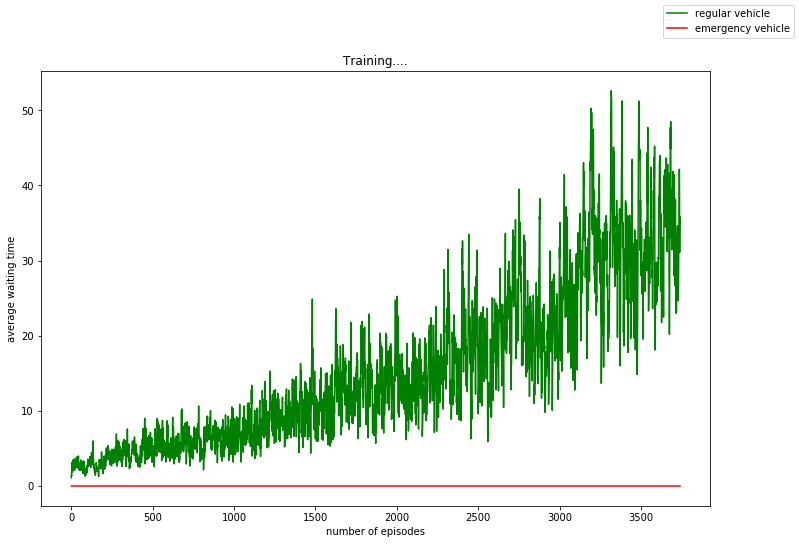

In [208]:
# vehicle average waiting time history
fig=plt.figure()
ax= fig.add_subplot(111)
fig.show()
fig.set_size_inches(12,8)
                    
plot(episode_count,regular_waiting_history,'average waiting time',color='green',label='regular vehicle')
plot(episode_count,emergency_waiting_history,'average waiting time',color='red',label='emergency vehicle')
fig.legend()

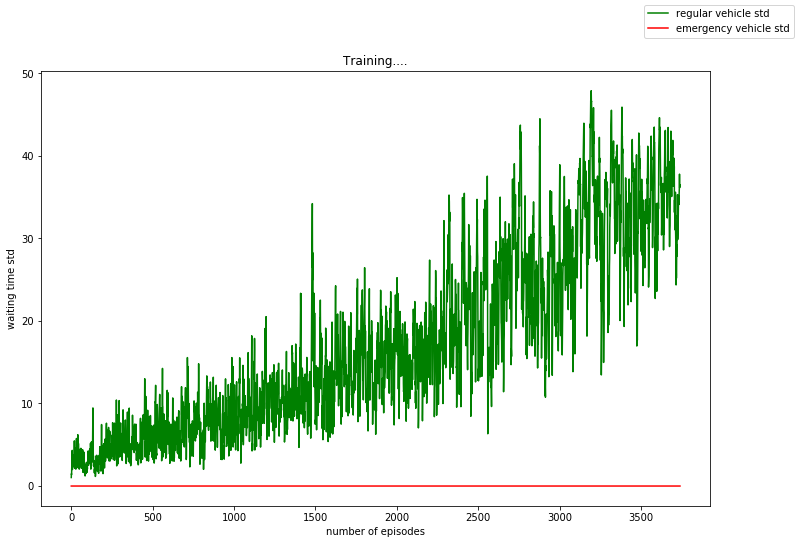

In [209]:
# vehicle waiting time std history
fig=plt.figure()
ax= fig.add_subplot(111)
fig.show()
fig.set_size_inches(12,8)

plot(episode_count,regular_std_history,'waiting time std',color='green',label='regular vehicle std')
plot(episode_count,emergency_std_history,'waiting time std',color='red',label='emergency vehicle std')
fig.legend()

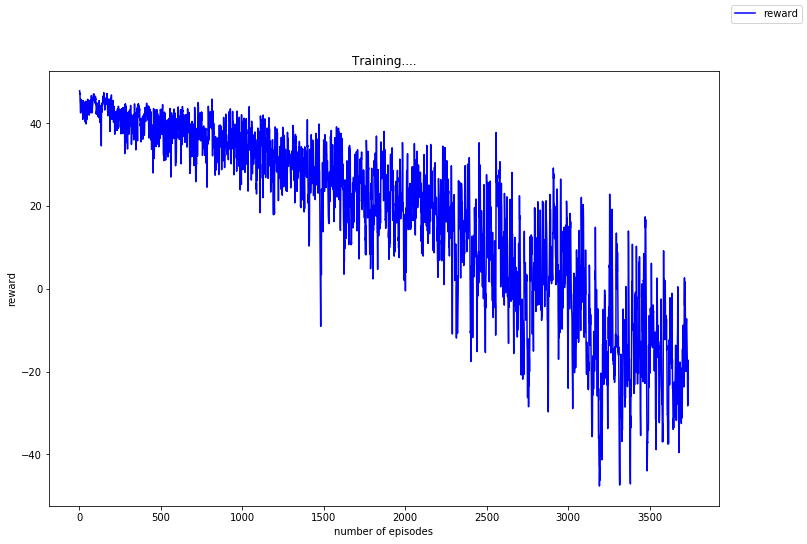

In [210]:
#reward history
fig=plt.figure()
ax= fig.add_subplot(111)
fig.show()
fig.set_size_inches(12,8)

plot(episode_count,reward_history,'reward',color='blue',label='reward')
fig.legend()